# Implicit learning of visual ensembles during visual search in children with ASD

**Researchers: Sander Van de Cruys, Lisa Lemmens, Andrey Chetverikov, Laurie-Anne Sapey-Triomphe, Ilse Noens, Johan Wagemans**
___


See task,  procedure and participant description in the [Manuscript draft](https://docs.google.com/document/d/1N63YVUppCZ2AC4IBXmuS6sWog9-t3Xsq8YmCbZ6DMPo/edit?usp=sharing)

TODO:



Notes:

* Warning: This is a working document, and may contain coding or reasoning errors...
* Errorbars are 95% ci's (for the python plots)


<img src="img/task.jpg" style="height:800px">


# Importing the required python libraries:

In [12]:
import glob, os #file utilities
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt # roughly ~base R plotting functionality
import pandas as pd #roughly ~base R & tidyr functionality 
import seaborn as sns #roughly ~ggplot2 functionality
import statsmodels.api as sm
from statsmodels import stats
#from scipy import stats
import statsmodels.formula.api as smf
from bambi import Model
import pymc3 as pm
import bambi
import warnings
import ptitprince as pt # python version of rain cloud plots
import pingouin as pg # statistical tests
import rpy2
from sklearn import preprocessing #for scale function
warnings.filterwarnings('ignore')

#to make the plots appear inline, and saved in notebook:
%matplotlib inline
sns.set_context("paper") # seaborn function to make plots according to purpose (talk, paper, poster, notebook)

# We'll show people what versions we use
import datetime
now  = datetime.datetime.now().isoformat()
print('Ran on ' + now)
import IPython
print(IPython.sys_info())
#!pip freeze | grep -E 'seaborn|matplotlib|pandas|statsmodels|pingouin'

def save_fig(fig, figname):
    fig.savefig("../figs/%s.pdf" % figname, dpi=300)
    fig.savefig("../figs/%s.png" % figname, dpi=300)
    fig.savefig("../figs/%s.svg" % figname, dpi=300)

%load_ext watermark
%watermark -v -m -p scipy,numpy,rpy2,sklearn,seaborn,statsmodels,pandas,matplotlib,pingouin -g

Ran on 2020-07-08T15:21:25.169646
{'commit_hash': 'e78905a3c',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/home/sander/.local/lib/python3.8/site-packages/IPython',
 'ipython_version': '7.14.0',
 'os_name': 'posix',
 'platform': 'Linux-5.4.0-39-generic-x86_64-with-glibc2.29',
 'sys_executable': '/usr/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.8.2 (default, Apr 27 2020, 15:53:34) \n[GCC 9.3.0]'}
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.8.2
IPython 7.14.0

scipy 1.4.1
numpy 1.18.4
rpy2 3.3.2
sklearn 0.0
seaborn 0.10.1
statsmodels 0.11.1
pandas 1.0.3
matplotlib 3.2.1
pingouin 0.3.3

compiler   : GCC 9.3.0
system     : Linux
release    : 5.4.0-39-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : f8ae5e03ea95a0f3679e7e290ab5e87de20ba6e7


# Import R interface, libraries

In [3]:
import rpy2.rinterface
%reload_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%R 

library(lme4)
library(segmented)
library(ggplot2)
library(BayesFactor)
library(lmerTest)
library(ggpubr)
library(cowplot)
library(readr)
library(tidyverse)



Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Attaching package: ‘lmerTest’



    lmer



    step


  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

********************************************************



  theme_set(theme_cowplot())



Attaching package: ‘cowplot’



    get_legend



✔ tidyr   1.0.3     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.0

✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



# Import and inspect data

In [4]:
# importing data
df = pd.DataFrame()    
all_files = glob.glob(os.path.join('Data','Exp', "*.csv")) # get list of individual data files
all_files.sort()

import re 

for file in all_files:
    idcode = re.findall('\d+', file)[0]
    dfnew = pd.read_csv(file).assign(subjectId=int(idcode)) #read file and add column for id
    df = pd.concat([df, dfnew], ignore_index=True)

df['group'] = np.where(df['subjectId']<100, 'ASD', 'TD')
df["subjectId"] = df["subjectId"].astype('str')

# Select informative variables and add new variables

In [5]:
vars = ['expName','subjectId','group','session','blockN', 'totBlockN', 'trialN','targetOri','targetPos', 'targetRow','distrMean','dtype','dsd','targetDist','prevDistrMean','streak_length_prime', 'seq_type','answer','rt','correct','d_ori_1', 'd_ori_2','d_ori_3', 'd_ori_4', 'd_ori_5', 'd_ori_6', 'd_ori_7', 'd_ori_8', 'd_ori_9', 'd_ori_10', 'd_ori_11', 'd_ori_12', 'd_ori_13', 'd_ori_14', 'd_ori_15', 'd_ori_16', 'd_ori_17', 'd_ori_18', 'd_ori_19', 'd_ori_20', 'd_ori_21', 'd_ori_22', 'd_ori_23', 'd_ori_24', 'd_ori_25', 'd_ori_26', 'd_ori_27', 'd_ori_28', 'd_ori_29', 'd_ori_30', 'd_ori_31', 'd_ori_32', 'd_ori_33', 'd_ori_34', 'd_ori_35']

df= df[vars]


#correcting for vertical ori not at 0 in experiment code
df['targetOri'] = -(df.targetOri-225)
df['distrMean'] = -(df.distrMean-225)


#function to calculate difference between two angles (from Andrey)
def angle_dist_180(a,b):
    c = a - b
    return (c+90)%180 - 90


df = df.assign(rt=df.rt*1000, 
        previous_correct = df.correct.shift(1), #Previous trial correct
        previous_target = df.targetOri.shift(1), #Previous target orientation
        log_rt = np.log(df.rt), 
        rt_inv= 1/df.rt,       
        ctpd= angle_dist_180(df.targetOri,df.prevDistrMean), #CT-PD: difference between current target ori and previous distractor ori mean. 
        cdpd = angle_dist_180(df.distrMean,df.prevDistrMean), #CD-PD: difference between current distractor ori mean and previous distractor ori    mean.
        targetDist_ang = angle_dist_180(df.distrMean,df.targetOri))

df['cdpt'] = angle_dist_180(df.distrMean,df.previous_target) #CD-PT: difference between current distractor ori mean and previous target ori.
df['ctpt'] = angle_dist_180(df.targetOri,df.previous_target) #CT-PT: difference between current target ori mean and previous target ori.


df['abs_ctpd'] = abs(df.ctpd) #absolute value of CT-PD
df['abs_cdpt'] = abs(df.cdpt) #absolute value of CD-PT
df['abs_ctpt'] = abs(df.ctpt) # absolute value of CT-PT
df['abs_cdpd'] = abs(df.cdpd)
df['dsd_a'] = df.filter(regex=("d_ori.*")).std(axis=1) #compute actual distractor ori sd

df['distrMean'] = np.where(df.distrMean > 90, df.distrMean - 180, df.distrMean) #Convert them to orientations between -90° & + 90°
df.distrMean = np.where(df.distrMean < -90, df.distrMean + 180, df.distrMean)
df.distrMean = np.where(df.distrMean > 90, df.distrMean - 180, df.distrMean)
df.distrMean = np.where(df.distrMean> 90, df.distrMean - 180, df.distrMean)
df['targetOri'] = np.where(df.targetOri > 90, df.targetOri - 180, df.targetOri)
df.targetOri = np.where(df.targetOri < -90, df.targetOri + 180, df.targetOri)
df.targetOri = np.where(df.targetOri > 90, df.targetOri - 180, df.targetOri)
df.targetOri = np.where(df.targetOri > 90, df.targetOri - 180, df.targetOri)

df['ctpd_2'] = df.ctpd**2 #Quadratic predictors
df['ctpt_2'] = df.ctpt**2
df['targetDist_ang_2'] = df.targetDist_ang**2


scaled= [('rt_z', 'rt'),('ctpd_z','ctpd'), ('cdpt_z', 'cdpt'), ('ctpt_z', 'ctpt'),('cdpd_z','cdpd'), ('abs_ctpd_z', 'abs_ctpd'),('abs_ctpt_z','abs_ctpt'), ('abs_cdpd_z','abs_cdpd'), ('ctpd_z2', 'ctpd_2'), ('ctpt_z2', 'ctpt_2'),('targetDist_ang_z_2', 'targetDist_ang_2')]

for var in scaled: 

    df[var[0]] = df.groupby(['subjectId'])[var[1]].transform(preprocessing.scale)

# adding variables to indicate transition between sequence types (unequal len of sequences), prime or probe 
df['block_len'] = df.groupby(['subjectId','totBlockN'])['rt'].transform('count')
df['is_last'] = np.where(df.trialN==5,1,0)       
df.is_last = np.where((df.dsd == 10) & (df.block_len == 6) & (df.trialN==5),1,df.is_last)
df.is_last = np.where((df.dsd == 10) & (df.block_len == 5) & (df.trialN==4),1,df.is_last)
df.is_last = np.where((df.dsd == 5) & (df.block_len == 1) & (df.trialN==0),1,df.is_last) 
df.is_last = np.where((df.dsd == 5) & (df.block_len == 2) & (df.trialN==1),1,df.is_last) 

df['transprime'] = np.where((df.dsd == 10) & (df.is_last ==1),0,np.NaN)
df.transprime = np.where((df.dsd == 5) & (df.trialN ==0),1,df.transprime)
df['transprobe'] = np.where((df.dsd == 5) & (df.is_last ==1),0,np.NaN)
df.transprobe = np.where((df.dsd == 10) & (df.trialN ==0),1,df.transprobe)

# quantized version of distance between target ori and dsd mean
df['tDist'] = pd.qcut(df.targetDist_ang_z_2, 10, range(1,11))
df['tDist'] = df.tDist.astype('int32')

df['in_range'] = np.where(df.abs_ctpd > 30, "out", "in")



In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44281 entries, 0 to 44280
Data columns (total 89 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   expName              44281 non-null  object 
 1   subjectId            44281 non-null  object 
 2   group                44281 non-null  object 
 3   session              44281 non-null  int64  
 4   blockN               44281 non-null  int64  
 5   totBlockN            44281 non-null  int64  
 6   trialN               44281 non-null  int64  
 7   targetOri            44281 non-null  float64
 8   targetPos            44281 non-null  int64  
 9   targetRow            44281 non-null  int64  
 10  distrMean            44281 non-null  float64
 11  dtype                44281 non-null  object 
 12  dsd                  44281 non-null  int64  
 13  targetDist           44281 non-null  int64  
 14  prevDistrMean        44014 non-null  float64
 15  streak_length_prime  44281 non-null 

In [328]:
df.iloc[:30,:20]

,expName,subjectId,group,session,blockN,totBlockN,trialN,targetOri,targetPos,targetRow,distrMean,dtype,dsd,targetDist,prevDistrMean,streak_length_prime,seq_type,answer,rt,correct
0,orientation_search,1,ASD,1,0,0,0,3.6,31,1,84.599572,norm,10,99,NaN,6,prime,up,1201.695831,0
1,orientation_search,1,ASD,1,0,0,1,-35.4,21,3,84.599572,norm,10,60,NaN,6,prime,up,1810.640007,1
2,orientation_search,1,ASD,1,0,0,2,16.6,25,1,84.599572,norm,10,112,NaN,6,prime,up,2246.566126,0
3,orientation_search,1,ASD,1,0,0,3,-16.4,30,0,84.599572,norm,10,79,NaN,6,prime,down,2438.014591,1
4,orientation_search,1,ASD,1,0,0,4,18.6,20,2,84.599572,norm,10,114,NaN,6,prime,down,4845.820144,1
5,orientation_search,1,ASD,1,0,0,5,4.6,19,1,84.599572,norm,10,100,NaN,6,prime,down,4405.121540,1
6,orientation_search,1,ASD,1,1,1,0,-48.1,34,4,30.910955,norm,5,79,84.599572,6,probe,up,1373.607321,1
7,orientation_search,1,ASD,1,1,1,1,-48.1,13,1,19.910955,norm,5,68,84.599572,6,probe,down,1449.623583,1
8,orientation_search,1,ASD,1,2,2,0,55.6,16,4,-37.442700,norm,10,93,84.599572,6,prime,up,2613.396101,1
9,orientation_search,1,ASD,1,2,2,1,38.6,32,2,-37.442700,norm,10,76,84.599572,6,prime,down,1736.839293,1


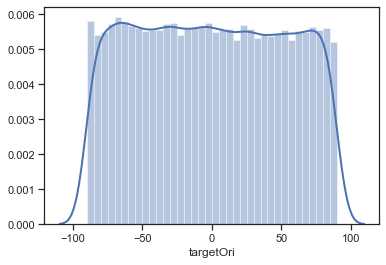

In [329]:
#sns.distplot(df.cdpt.dropna()) 
#sns.distplot(df.ctpd.dropna())
#sns.distplot(df.ctpt.dropna())
#sns.distplot(df.cdpd.dropna())
sns.distplot(df.targetOri.dropna())
#sns.distplot(df.targetDist_ang.dropna())
#sns.distplot(df[(df.correct ==1) & (df.dsd == 5)].distrMean.dropna())


In [10]:
# count missing values
#df.isnull().sum().head(60)

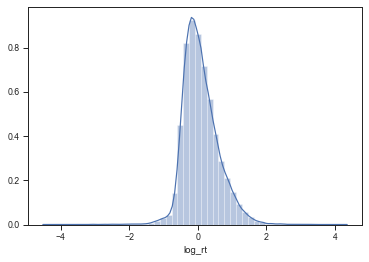

In [9]:
sns.distplot(df.log_rt.dropna())


# Inspect data characteristics

In [10]:
print('Variables:\n', df.columns)
print('variables:\n', df.dtypes)
print('nb of participants:', len(df['subjectId'].unique()))
df.groupby('group')['subjectId'].nunique()

Variables:
 Index(['expName', 'subjectId', 'group', 'session', 'blockN', 'totBlockN',
       'trialN', 'targetOri', 'targetPos', 'targetRow',
       ...
       'IU', 'CBCL', 'SP', 'ADOS', 'ADOS_SA', 'ADOS_BRG', 'TIQ', 'SRSsplit',
       'SPsplit', 'IUsplit'],
      dtype='object', length=110)
variables:
 expName        object
subjectId      object
group          object
session         int64
blockN          int64
               ...   
ADOS_BRG      float64
TIQ           float64
SRSsplit     category
SPsplit      category
IUsplit      category
Length: 110, dtype: object
nb of participants: 49


group
ASD    24
TD     25
Name: subjectId, dtype: int64

## Explanation of variables:
    
- d_ori_xx = orientation of line number xx (goes from 0 to 35 where 0 is top left corner of a stimuli matrix and 35 is a bottom right corner; the stimuli matrix is filled by column, so item 0 has coordinates of [-8., -8.], item 1 has coordinates of [-8., -4.8.], item 5 - array([-8.,  8.]), and item 6 -  [-4.8, -8. ])
- set_size = number of lines in one set (always 36 here)
- stim_pos_x_30 = position of line number xx
- test_set_size = number of lines in test set (always 36)
- targetCol = column in which target is located
- dsd_test = distractors distribution SD of the test trials (always 5 here)
- seq_type = is it a prime trial or a test trial
- dsd = distractors distribution SD
- blockRepN = repetition of the different combinations of conditions (5 times here)
- targetDist - distance (in orientation) between targetOri and distrMean
- dtype_test = type of test distribution (always normal)
- prime_set_size = set size prime trials (always 36)
- correctResponse = what the correct response is
- dtype = distribution type (always normal)
- distrMean = mean of distractors orientation
- targetRow = row in which target is located
- dsd_prime = distractors distribution SD of prime trials
- streak_length_prime = number of trials in prime streaks (5 or 6)
- targetOri = target orientation 
- targetPos = position of target
- trialN = trial number within test or prime streak
- dtype_prime = distribution type in prime trials
- totBlockN = total number of streaks/blocks
- blockN = number of blocks per repetition of all conditions
- prevDistrCTPD = previous difference between target orientation and previous distractor mean
- prevDistrMean = previous distribution mean
- prevDistrType = previous distribution type
- answer = reponse (down or up)
- rt = reaction time
- correct = accuracy 
- trialScore
- session
- participant

# Remove outliers

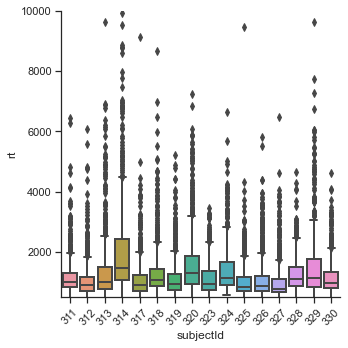

In [344]:
ax= sns.catplot(x="subjectId", y="rt", kind="box", data=df[(pd.to_numeric(df.subjectId)>310) & (df.group=='TD')]); #
ax.set_xticklabels(rotation=45)
ax.set(ylim=[500,10000])

In [346]:
print(len(df))
df = df[df.subjectId!='314']
len(df)

43126


42501

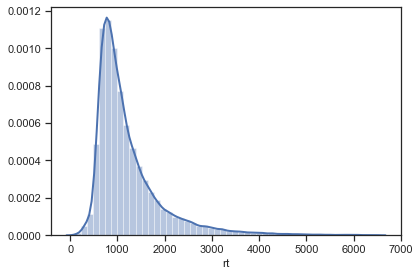

In [347]:
g= sns.distplot(df.rt[(df.rt<6500) & (df.rt>100)],bins=50) 


## Robust Outlier Detection using the T Distribution

http://eointravers.com/post/outliers/

In [28]:
from scipy import stats

def detect_outliers_t(df, k=3):
    '''Detect outliers by fitting t distribution to data.
    Args:
        x: np.array of data
        k: Exclude points within ±k×s of mean.
    Returns:
        is_outlier: np.array indicating whether each point is an outlier
        outlier_pars: dict of paramters of t distribution
    '''
    
    t_df, t_m, t_s = stats.t.fit(df.log_rt)
    is_outlier = np.abs( df.log_rt - t_m) < k * t_s
    outlier_pars = {
        'm': t_m, 's': t_s, 'df': t_df, 'p_outlier': 1-is_outlier.mean(), 'k': k
    }
    return  is_outlier #, outlier_pars


countsBefore = df.groupby(['group']).rt.count()

df = df[df.rt>100] # remove implausibly low rts

# remove outliers per person based on t distribution
df= df[df.groupby('subjectId', as_index=False).apply(detect_outliers_t).reset_index().log_rt.values]

countsAfter = df.groupby(['group']).rt.count()

counts= countsBefore.reset_index()

counts['after']= countsAfter.reset_index().rt
counts['nlost']= counts.rt-counts.after
counts['perc_lost']= (counts.nlost/counts.rt)*100

counts

,group,rt,after,nlost,perc_lost
0,ASD,21869,21369,500,2.286341
1,TD,22412,21757,655,2.922541


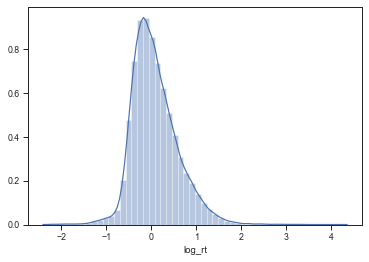

In [17]:
sns.distplot(df.log_rt) 


## Remove outliers the conventional way (used in paper)

In [6]:
countsBefore = df.groupby(['group']).rt.count()

#df = df[df.rt<(df.rt.mean()+(df.rt.std()*3))] # remove very high rts
df = df[df.rt>100] # remove implausibly low rts
#df = df[df.subjectId!='314'] # participant with a higher range/mean

def filter_func(x):
    return x['rt'] < x['rt'].mean()+(3*x['rt'].std())

# remove extreme outliers per participant
df = df[df.groupby('subjectId').apply(filter_func).reset_index().rt.values]

countsAfter = df.groupby(['group']).rt.count()

counts= countsBefore.reset_index()

counts['after']= countsAfter.reset_index().rt
counts['nlost']= counts.rt-counts.after
counts['perc_lost']= (counts.nlost/counts.rt)*100

counts

,group,rt,after,nlost,perc_lost
0,ASD,21869,21445,424,1.938818
1,TD,22412,21937,475,2.119400


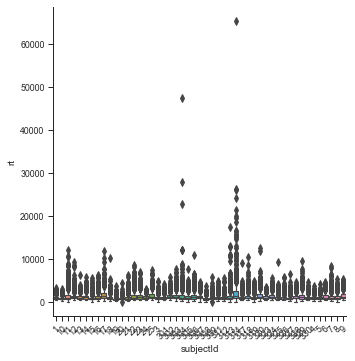

In [13]:
g = sns.catplot(x="subjectId", y="rt", kind="box", data=df[df.correct==1]);
g.set_xticklabels(rotation=45)


We used both types of outlier removal for the analyses, but this didn't matter much. So we report the second (more conventional) one.

# Add descriptive data

In [7]:
# add demographics
demo_asd = pd.read_csv("Data/deelnemers_ASD.csv")
demo_td = pd.read_csv("Data/CONTROLEdeelnemers.csv")

dfdescr = pd.concat([demo_asd, demo_td], ignore_index=True)

vars= ["SubjectId","leeftijd", "Geslacht", "VIQ", "PIQ","SRS_TOTAAL","SRS_SB", "SRS_SCOG", "SRS_SCOM", "SRS_SM", "SRS_AP", "IU","CBCL","SP", "ADOS","ADOS_SA","ADOS_BRG"]

dfdescr = dfdescr[vars]


dfdescr['TIQ'] = (dfdescr.PIQ + dfdescr.VIQ)/2

dfdescr.SubjectId[dfdescr.SubjectId=='016_goed']='016'
dfdescr = dfdescr[dfdescr.SubjectId.notna()]

dfdescr.SubjectId= dfdescr.SubjectId.astype(int)
#dfdescr.SRS_TOTAAL = pd.to_numeric(dfdescr.SRS_TOTAAL)
#dfdescr.SP = pd.to_numeric(dfdescr.SP)
#dfdescr.SP = pd.to_numeric(dfdescr.SP)

for i in dfdescr.columns:
    if i=='SubjectId':
        continue
    dfdescr[i] = pd.to_numeric(dfdescr[i], errors='coerce')

dfdescr.SubjectId= dfdescr.SubjectId.astype(str)


In [43]:
dfdescr.head()

,SubjectId,leeftijd,Geslacht,VIQ,PIQ,SRS_TOTAAL,SRS_SB,SRS_SCOG,SRS_SCOM,SRS_SM,SRS_AP,IU,CBCL,SP,ADOS,ADOS_SA,ADOS_BRG,TIQ
0,1,10.22,0.0,92.0,97.0,91,67.0,89.0,91.0,73.0,89.0,39.0,60.0,NaN,5.0,5.0,0.0,94.5
1,2,13.66,0.0,62.0,91.0,95,67.0,102.0,87.0,78.0,95.0,41.0,70.0,142.0,3.0,3.0,0.0,76.5
2,3,11.40,0.0,122.0,103.0,86,63.0,82.0,87.0,67.0,89.0,NaN,NaN,162.0,14.0,NaN,NaN,112.5
3,4,10.72,0.0,127.0,120.0,77,73.0,71.0,65.0,65.0,92.0,47.0,66.0,NaN,9.0,7.0,2.0,123.5
4,5,11.93,0.0,114.0,132.0,96,83.0,94.0,85.0,83.0,92.0,53.0,57.0,180.0,5.0,5.0,0.0,123.0


In [8]:
df= pd.merge(df, dfdescr, how='left', left_on='subjectId', right_on='SubjectId')
#add variable split SRS
df['SRSsplit'] = pd.qcut(df.SRS_TOTAAL, 3, labels=['low','mid','high'])
df['SPsplit'] = pd.qcut(df.SP, 2, labels=['low','high'])
df['IUsplit'] = pd.qcut(df.IU, 2, labels=['low','high'])
df.head()

,expName,subjectId,group,session,blockN,totBlockN,trialN,targetOri,targetPos,targetRow,...,IU,CBCL,SP,ADOS,ADOS_SA,ADOS_BRG,TIQ,SRSsplit,SPsplit,IUsplit
0,orientation_search,1,ASD,1,0,0,0,41.4,31,1,...,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high,NaN,high
1,orientation_search,1,ASD,1,0,0,1,80.4,21,3,...,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high,NaN,high
2,orientation_search,1,ASD,1,0,0,2,28.4,25,1,...,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high,NaN,high
3,orientation_search,1,ASD,1,0,0,3,61.4,30,0,...,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high,NaN,high
4,orientation_search,1,ASD,1,1,1,0,-86.9,34,4,...,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high,NaN,high


In [56]:
df.to_csv('preproc_df.csv')

# Do matching on IQ, gender and age

### Age

leeftijd                                                        \
         count       mean       std    min    25%     50%        75%   
group                                                                  
ASD       24.0  12.048533  1.300072  10.22  10.92  11.845  13.163733   
TD        25.0  11.850679  1.500949  10.01  10.90  11.520  12.643836   

                  
             max  
group             
ASD    14.986301  
TD     14.947945

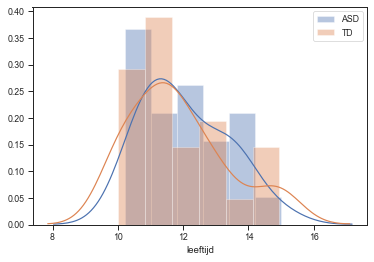

In [21]:
dfm = df.groupby(['group', 'subjectId']).leeftijd.mean().reset_index()

sns.distplot(dfm[dfm.group=='ASD'].leeftijd.dropna(), label="ASD", bins=6)
sns.distplot(dfm[dfm.group=='TD'].leeftijd.dropna(), label="TD", bins=6)
plt.legend();

dfm.groupby(['group']).describe()

In [30]:
pg.ttest(dfm[dfm.group=="ASD"].leeftijd, dfm[dfm.group=="TD"].leeftijd, paired=False, tail='two-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.49,46.52,two-sided,0.62,"[-0.61, 1.0]",0.14,0.315,0.08


### IQ

TIQ                                                         
      count        mean        std   min    25%    50%    75%    max
group                                                               
ASD    23.0  105.043478  13.275844  82.5   96.5  102.5  115.5  123.5
TD     25.0  105.860000   9.395832  84.5  103.0  107.0  108.5  131.0

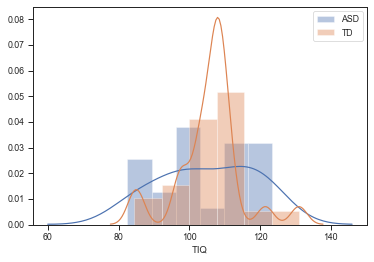

In [106]:
dfm = df.groupby(['group', 'subjectId']).TIQ.mean().reset_index()

sns.distplot(dfm[dfm.group=='ASD'].TIQ.dropna(), label="ASD", bins=6)
sns.distplot(dfm[dfm.group=='TD'].TIQ.dropna(), label="TD", bins=6)
plt.legend();

dfm.groupby(['group']).describe()

In [107]:
pg.ttest(dfm[dfm.group=="ASD"].TIQ, dfm[dfm.group=="TD"].TIQ, paired=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.24,39.3,less,0.4,"[-inf, 4.82]",0.07,0.589,0.08


In [32]:
dfm = df.groupby(['group', 'subjectId']).VIQ.mean().reset_index()
pg.ttest(dfm[dfm.group=="ASD"].VIQ, dfm[dfm.group=="TD"].VIQ, paired=False, tail='two-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.11,37.92,two-sided,0.92,"[-8.08, 8.98]",0.03,0.286,0.05


In [33]:
dfm.groupby(['group']).describe()

VIQ                                                      
      count    mean        std   min     25%    50%    75%    max
group                                                            
ASD    24.0  105.25  17.673980  57.0   98.75  109.5  114.0  130.0
TD     25.0  104.80  10.858944  68.0  100.00  106.0  111.0  122.0

In [34]:
dfm = df.groupby(['group', 'subjectId']).PIQ.mean().reset_index()
pg.ttest(dfm[dfm.group=="ASD"].PIQ, dfm[dfm.group=="TD"].PIQ, paired=False, tail='two-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.31,44.45,two-sided,0.76,"[-10.46, 7.7]",0.09,0.296,0.06


In [35]:
dfm.groupby(['group']).describe()

PIQ                                                         
      count        mean        std   min    25%    50%    75%    max
group                                                               
ASD    24.0  105.541667  17.232374  74.0   90.5  107.0  120.0  132.0
TD     25.0  106.920000  14.088766  66.0  100.0  106.0  111.0  143.0

### CBCL

CBCL                                                   
      count       mean       std   min   25%   50%   75%   max
group                                                         
ASD    20.0  58.200000  7.918001  50.0  51.5  56.0  63.0  77.0
TD     21.0  54.666667  5.876507  50.0  50.0  51.0  57.0  66.0

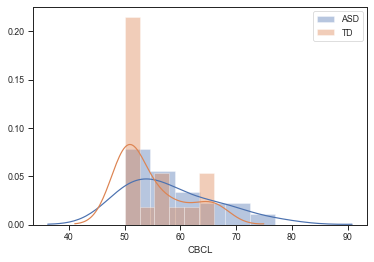

In [37]:
dfm = df.groupby(['group', 'subjectId']).CBCL.mean().reset_index()
sns.distplot(dfm[dfm.group=='ASD'].CBCL.dropna(), label="ASD", bins=6)
sns.distplot(dfm[dfm.group=='TD'].CBCL.dropna(), label="TD", bins=6)
plt.legend();

dfm.groupby(['group']).describe()

In [38]:
pg.ttest(dfm[dfm.group=="ASD"].CBCL, dfm[dfm.group=="TD"].CBCL, paired=False, tail='two-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.62,35.01,two-sided,0.12,"[-0.9, 7.97]",0.51,0.854,0.36


### Gender (number of females)

In [9]:
dfm = df.groupby(['group', 'subjectId']).Geslacht.mean().reset_index()
dfc = dfm.groupby(['group']).Geslacht.sum().reset_index()
dfc

,group,Geslacht
0,ASD,8.0
1,TD,12.0


In [13]:
count = dfc.Geslacht.values.tolist()
nobs= dfm.groupby(['group']).Geslacht.count().reset_index().Geslacht.values.tolist()
stats.proportion.proportions_chisquare(count,nobs, value=None)[:2]

(1.0903908045977015, 0.2963846354356077)

# Explore questionnaire data


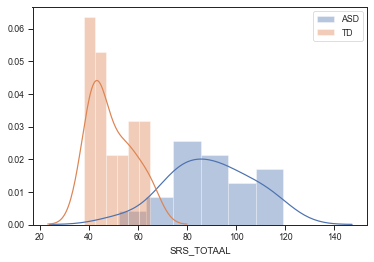

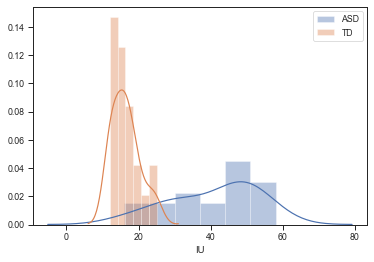

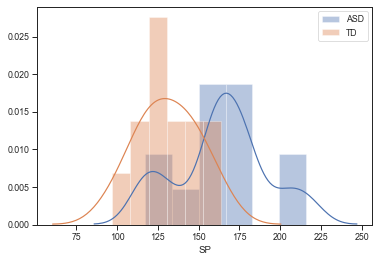

In [32]:
dfsumQ= df.groupby(['subjectId', 'group']).agg({'SRS_TOTAAL':'mean', 'SP': 'mean', 'IU': 'mean'}).reset_index()

for i in ['SRS_TOTAAL', 'IU', 'SP']:
    plt.figure()
    g = sns.distplot(dfsumQ[dfsumQ.group=='ASD'][i].dropna(), label="ASD", bins=6)
    sns.distplot(dfsumQ[dfsumQ.group=='TD'][i].dropna(), label="TD", bins=6)
    plt.legend()

"The SRS has high internal consistency (Cronbach’s alpha = 0.76), and has good discriminant validity (Constantino 2002). Sensitivity and specificity are 0.85 and 0.75, respectively, when the SRS total score of 75 is used as the cutoff (Bölte et al. 2011; Constantino 2002)." (Moody et al 2017)

In [37]:
df.SRS_TOTAAL.quantile([.33,.67])

0.33    52.0
0.67    80.0
Name: SRS_TOTAAL, dtype: float64

In [81]:
df[(df.SRS_TOTAAL>52) & (df.SRS_TOTAAL<80)  & (df.group=='ASD')].subjectId.unique()

array(['4', '8', '17', '22', '24', '25'], dtype=object)

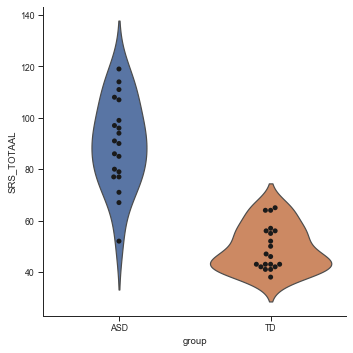

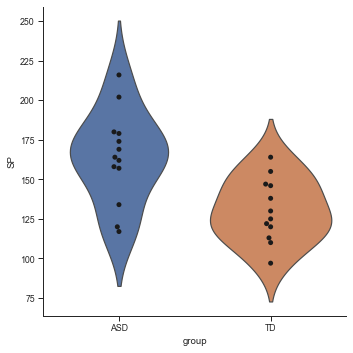

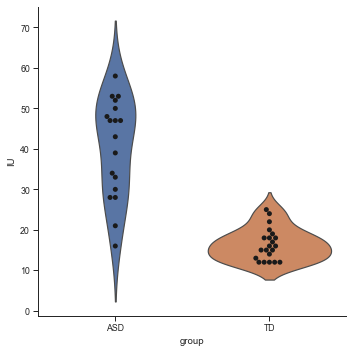

In [189]:
g = sns.catplot(x="group", y="SRS_TOTAAL", kind="violin", inner=None, data=dfsumQ);
sns.swarmplot(x="group", y="SRS_TOTAAL", color='k', size=5, data=dfsumQ, ax=g.ax);
g = sns.catplot(x="group", y="SP", kind="violin", inner=None, data=dfsumQ);
sns.swarmplot(x="group", y="SP", color='k', size=5, data=dfsumQ, ax=g.ax);
g = sns.catplot(x="group", y="IU", kind="violin", inner=None, data=dfsumQ);
sns.swarmplot(x="group", y="IU", color='k', size=5, data=dfsumQ, ax=g.ax);

Missing questionnaire data:

In [48]:
dfsumQ.SP.isna().sum(), dfsumQ.SRS_TOTAAL.isna().sum(), dfsumQ.IU.isna().sum()

(23, 7, 8)

In [126]:
dfsumQ.groupby(['group']).SP.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ASD,13.0,164.000000,28.705400,117.0,157.0,164.0,179.0,216.0
TD,13.0,131.153846,19.156575,97.0,120.0,130.0,146.0,164.0


In [44]:
dfsumQ.groupby(['group']).describe()

SRS_TOTAAL                                                         SP  \
           count       mean        std   min   25%   50%   75%    max count   
group                                                                         
ASD         21.0  89.333333  16.992155  52.0  77.0  90.0  99.0  119.0  13.0   
TD          21.0  49.000000   8.608136  38.0  42.0  46.0  56.0   65.0  13.0   

                   ...                  IU                                     \
             mean  ...    75%    max count       mean        std   min    25%   
group              ...                                                          
ASD    164.000000  ...  179.0  216.0  19.0  40.842105  12.028961  16.0  31.50   
TD     131.153846  ...  146.0  164.0  22.0  16.409091   3.850282  12.0  13.25   

                         
        50%   75%   max  
group                    
ASD    47.0  49.5  58.0  
TD     16.0  18.0  25.0  

[2 rows x 24 columns]

In [43]:
pg.ttest(dfsumQ.query('group=="ASD"').SRS_TOTAAL, dfsumQ.query('group=="TD"').SRS_TOTAAL, paired=False, tail='two-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,9.7,40,two-sided,0.0,"[31.93, 48.73]",3.0,1.15e+09,1.0


In [189]:
pg.ttest(dfsumQ.query('group=="ASD"').SP, dfsumQ.query('group=="TD"').SP, paired=False, tail='two-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.43,24,two-sided,0.0,"[13.09, 52.6]",1.35,16.471,0.91


In [190]:
pg.ttest(dfsumQ.query('group=="ASD"').IU, dfsumQ.query('group=="TD"').IU, paired=False, tail='two-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,8.49,21.18,two-sided,0.0,"[18.45, 30.42]",2.83,3.026e+07,1.0


In [46]:
df.ADOS.describe()

count    21644.000000
mean         8.622805
std          4.060376
min          1.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         19.000000
Name: ADOS, dtype: float64

# General visual search performance

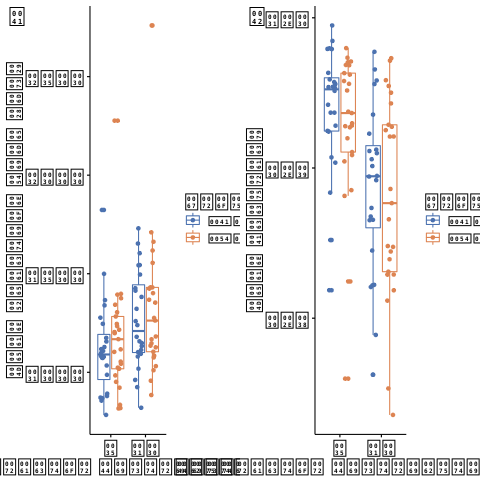

In [57]:
%%R 

df_filter <- suppressMessages(read_csv('preproc_df.csv'))


RTmeans_condition<- df_filter %>%
  filter(correct==1) %>% #only for correct responses
  group_by(subjectId,dtype,dsd,group) %>%
  summarise(mean_rt=mean(rt),sd_rt=sd(rt), mean_log_rt = mean(log_rt), sd_log_rt=sd(log_rt))

accmeans_condition<- df_filter %>%
  group_by(group,subjectId,dtype,dsd) %>%
  summarise(mean_acc=mean(correct),sd_acc=sd(correct))

means_condition <- RTmeans_condition%>%right_join(accmeans_condition, by=c("group","subjectId","dtype","dsd")) #RT and accuracy together

#summary table per group per condition
means_condition %>%
  group_by(group,dsd) %>%
  summarise(count = n(),acc=mean(mean_acc), sd_acc = sd(mean_acc), rt = mean(mean_rt), sd_rt=sd(mean_rt))

#Summary table per condition
means_condition %>%
  group_by(dsd) %>%
  summarise(count = n(),acc=mean(mean_acc), sd_acc = sd(mean_acc), rt = mean(mean_rt), sd_rt=sd(mean_rt))

#Plot RT data and acc data
plot_RT <- ggboxplot(means_condition, x = "dsd", y = "mean_rt", color = "group", add= "jitter", legend = "right", ylab="Mean Reaction Time (ms)", xlab = "Distractor Distribution SD" ) + scale_color_manual(values=c("#4c72b0", "#dd8452"))+ scale_x_discrete( limits=c("5","10"))
#+ ggtitle("Mean Reaction Time per Group and per Condition") +theme(plot.title = element_text(hjust = 0.5))

plot_acc<- ggboxplot(means_condition, x = "dsd", y = "mean_acc", color = "group", add= "jitter", legend = "right", ylab="Mean Accuracy", xlab = "Distractor Distribution SD" )+ scale_color_manual(values=c("#4c72b0", "#dd8452")) + scale_x_discrete( limits=c("5","10"))
# ggtitle("Mean Accuracy per Group and per Condition")+theme(plot.title = element_text(hjust = 0.5))
  
#Together in one figure with labels
plot_grid(plot_RT, plot_acc, labels = "AUTO")

In [9]:
dfsum = df.groupby(['group', 'subjectId', 'dsd']).mean().reset_index()
dfsumrt = df.query('(correct==1)').groupby(['group', 'subjectId', 'dsd']).mean().reset_index()
# compute inverse efficiency score (ies) to account for speed-accuracy trade off
dfsum['ies']= dfsum.rt/dfsum.correct


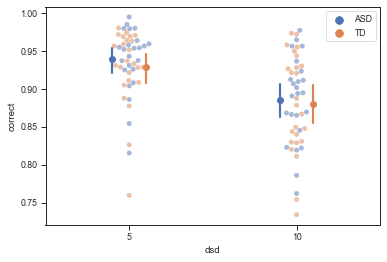

In [17]:
ax = sns.swarmplot(x='dsd',y='correct',hue="group", data=dfsum, alpha=0.5);
ax = sns.pointplot(x='dsd', hue= 'group', y='correct', 
                   data=dfsum, join=False, dodge=.2);
handles, labels = ax.get_legend_handles_labels();
ax.legend([handles[0], handles[1]], [labels[0],labels[1]]);

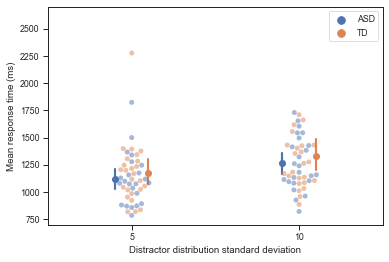

In [10]:
ax = sns.swarmplot(x='dsd',y='rt',hue="group", data=dfsumrt, alpha=0.5);
ax = sns.pointplot(x='dsd', hue= 'group', y='rt', 
                   data=dfsumrt, join=False, dodge=.2);
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[1]], [labels[0],labels[1]]);
ax.set_ylim([700,2700]);
ax.set(xlabel='Distractor distribution standard deviation', ylabel='Mean response time (ms)')

plt.savefig('rtbygroupdsd.png', dpi=300)

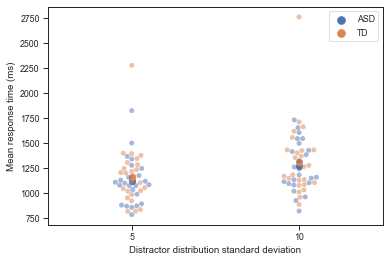

In [20]:
ax = sns.swarmplot(x='dsd',y='rt',hue="group", data=dfsumrt, alpha=0.5);
ax = sns.pointplot(x='dsd', hue= 'group', y='rt', unit='subjectId', 
                   data=df[(df.correct==1)], join=False);
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[1]], [labels[0],labels[1]]);
#ax.set_ylim([700,2700]);
ax.set(xlabel='Distractor distribution standard deviation', ylabel='Mean response time (ms)')

plt.savefig('rtbygroupdsd.png', dpi=300)

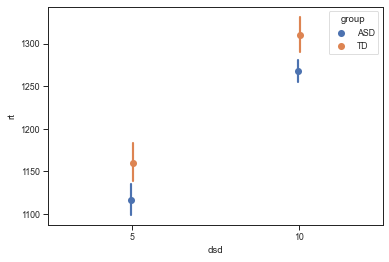

In [29]:
ax = sns.pointplot(x='dsd', hue= 'group', y='rt', unit='subjectId', 
                   data=df[(df.correct==1)], join=False, dodge=.01);
#ax = sns.swarmplot(x='dsd',y='rt',hue="group", data=dfsumrt, alpha=0.5);

#ax.set_ylim([700,1500]);


In [83]:
df[(df.correct==1)].groupby(['group', 'dsd']).rt.describe().reset_index()

,group,dsd,count,mean,std,min,25%,50%,75%,max
0,ASD,5,4338.0,1116.688579,602.126511,112.979705,769.794863,958.419693,1264.732385,10732.542012
1,ASD,10,14907.0,1268.634737,830.674896,129.115870,767.833486,1010.862259,1474.154520,12249.991926
2,TD,5,4324.0,1160.113592,760.329423,114.831817,786.058000,975.284728,1311.207210,18709.314094
3,TD,10,15207.0,1310.619023,1240.159840,107.214164,785.918950,1030.462977,1469.668709,65391.991227


In [88]:
df[(df.correct==1)].groupby(['dsd']).rt.describe().reset_index()

,dsd,count,mean,std,min,25%,50%,75%,max
0,5,8662.0,1138.365993,685.982185,112.979705,773.829105,967.248675,1291.470986,18709.314094
1,10,30114.0,1289.836007,1057.656003,107.214164,775.194488,1020.190848,1473.093716,65391.991227


## Post-error slowing?

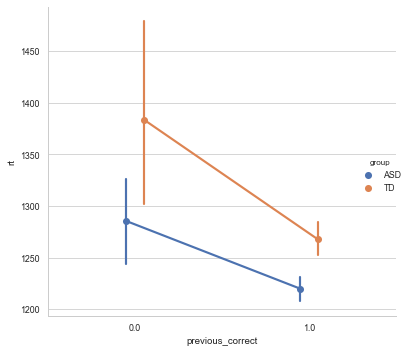

In [56]:
sns.catplot(x="previous_correct", y="rt", hue="group", unit="subjectId", kind="point",dodge=.1, data=df[df.correct==1]);

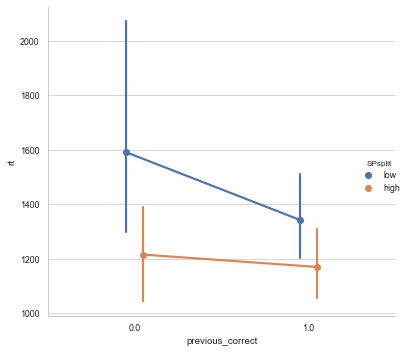

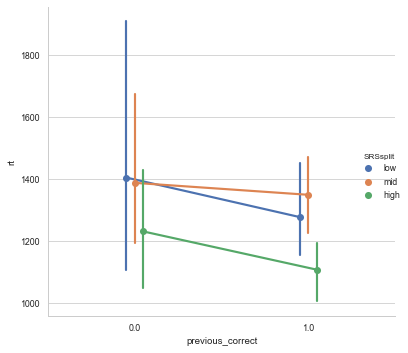

In [57]:
sns.catplot(x="previous_correct", y="rt", hue="SPsplit", units='subjectId', kind="point",dodge=.1, data=df[df.correct==1]);
sns.catplot(x="previous_correct", y="rt", hue="SRSsplit", units='subjectId', kind="point",dodge=.1, data=df[df.correct==1]);

In [68]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ dsd + C(previous_correct)*group", groups="subjectId",data=df[(df.correct==1)], family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                36297
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                 533
                      Estimating Equations   Max. cluster size:                 856
Family:                           Gaussian   Mean cluster size:               740.8
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                      wo, 22 apr 2020   Scale:                      994053.394
Covariance type:                    robust   Time:                         18:30:43
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                     

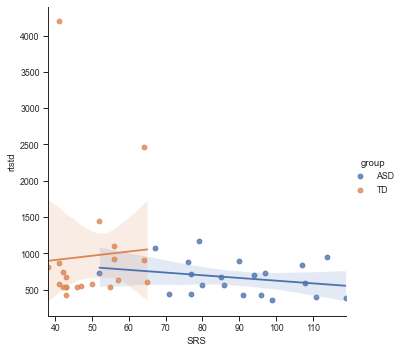

In [16]:
dfvar = df[(df.correct==1)].groupby(['subjectId','group']).agg(
    rtstd=pd.NamedAgg(column='rt', aggfunc='std'),
    SRS=pd.NamedAgg(column='SRS_TOTAAL', aggfunc='mean')).reset_index()
    
sns.lmplot(x="SRS", y="rtstd", hue="group", data=dfvar);

## Distance between target ori and dsd mean

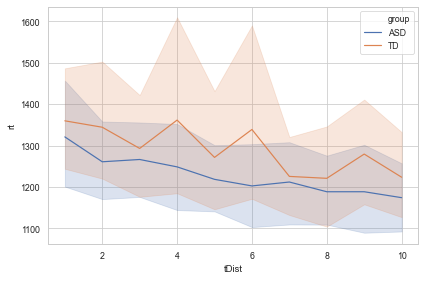

In [60]:
dfsumdist = df[(df.correct==1)].groupby(['group','subjectId', 'tDist']).rt.mean().reset_index()
sns.lineplot(x="tDist", y="rt", hue='group', data=dfsumdist);

In [70]:
%%R

df_filter$subjectId=factor(df_filter$subjectId)
df_filter$session=factor(df_filter$session)
df_filter$dsd = factor(df_filter$dsd)

##linear mixed model with DV = RT, IV within = dsd
lmer_rt<-lmer(log_rt ~ dsd * group + (dsd|subjectId), REML=F,control = lmerControl(optimizer ="Nelder_Mead"),  data = df_filter[which(df_filter$correct==1), ])
print(summary(lmer_rt))

#general linear mixed model with DV = correct, IV within = dsd
glmer_acc<- glmer(correct ~ dsd * group +(dsd|subjectId), family = binomial, data = df_filter)
summary(glmer_acc)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log_rt ~ dsd * group + (dsd | subjectId)
   Data: df_filter[which(df_filter$correct == 1), ]
Control: lmerControl(optimizer = "Nelder_Mead")

     AIC      BIC   logLik deviance df.resid 
 49662.4  49731.0 -24823.2  49646.4    38768 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4854 -0.6863 -0.1642  0.5504  7.9245 

Random effects:
 Groups    Name        Variance Std.Dev. Corr 
 subjectId (Intercept) 0.027705 0.16645       
           dsd10       0.004528 0.06729  -0.11
 Residual              0.209054 0.45722       
Number of obs: 38776, groups:  subjectId, 49

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    0.014470   0.034680 48.648555   0.417    0.678    
dsd10          0.079381   0.015843 48.009411   5.010 7.78e-06 ***
groupTD        0.029045   0.048576 48.745594   0.598    0.553    
dsd10:groupTD -0.008827

## Interim conclusion: overall visual search performance

There seem to be no substantial differences. Only a substantial effect for dsd (higher sd-> slower; more challenging. The literature on visual search in ASD find either faster search or no difference. But note that this concerns 'simpler' tasks that 

- Don't have the (manipulated) variability as we have here (dsd), distractors are more homogeneous in earlier studies, so simpler to disregard
- They often also don't have the odd-one-out character we have here, ie participants know what they have to search for.

So it is still interesting that ASD does not do worse here, they can deal with the variability (inferring the sameness in distractors to extract the deviant). Note that all the variability is relevant, in the sense that the more you can sample, the better the inference of what is same or different.

However, the data on the correlation with the social responsiveness scale (SRS; probing autism traits) casts a more nuanced picture. 

## Relation SRS, SP, IU and search performance

pearson r = -0.637 p-value =  0.001


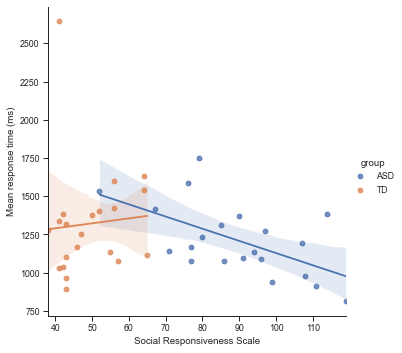

In [14]:
dfs = df.query('(correct==1)').groupby(['group', 'subjectId']).mean().reset_index()

g = sns.lmplot(x='SRS_TOTAAL', y="rt", hue="group", data=dfs);
g.set(xlabel='Social Responsiveness Scale', ylabel='Mean response time (ms)')
plt.savefig('srsbyrt.png', dpi=300)
r, p = stats.pearsonr(dfsum.dropna()['SRS_TOTAAL'], dfsum.dropna().rt)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

SRS_TOTAAL pearson r = -0.736 p-value =  0.01
SP pearson r = -0.579 p-value =  0.062
IU pearson r = -0.549 p-value =  0.08


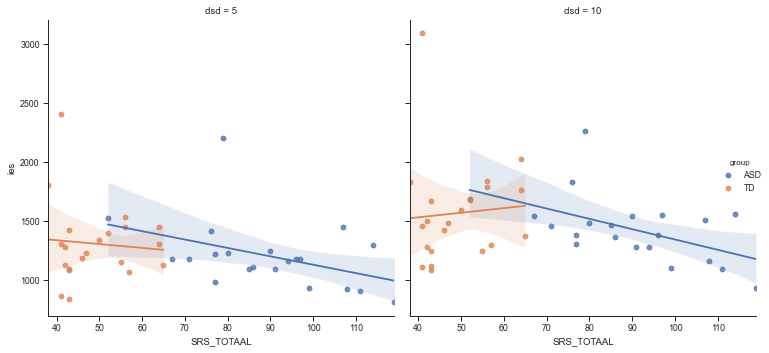

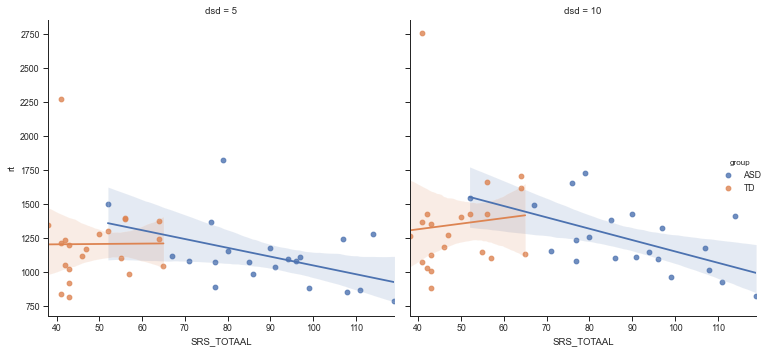

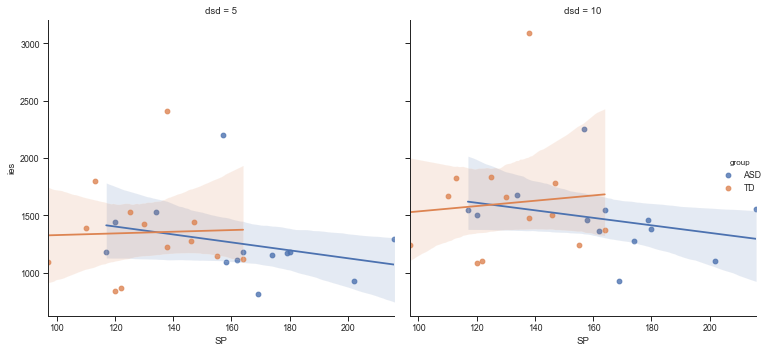

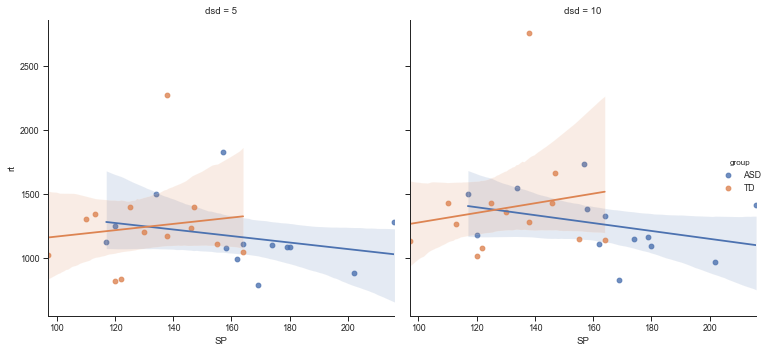

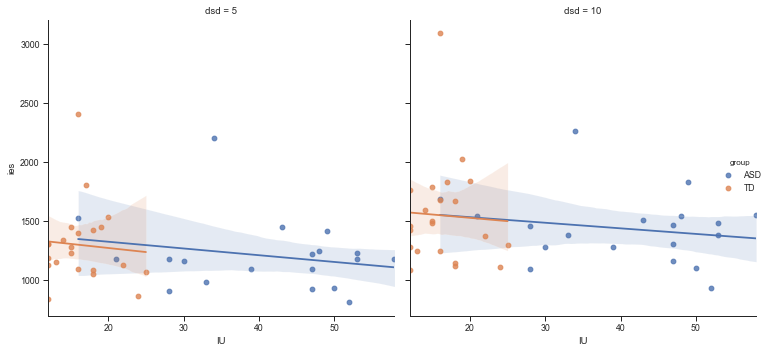

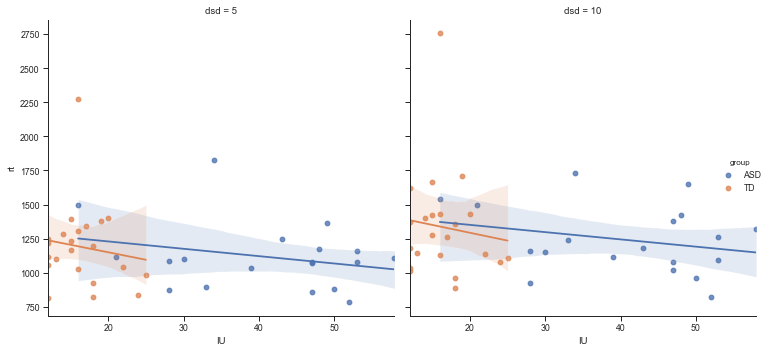

In [133]:
import scipy.stats  as stats

for i in ['SRS_TOTAAL', 'SP', 'IU']:

    sns.lmplot(x=i, y="ies", hue="group",
               col="dsd", data=dfsum);
    sns.lmplot(x=i, y="rt", hue="group",
           col="dsd", data=dfsumrt);
    r, p = stats.pearsonr(dfsum.dropna()[dfsum.dsd==10][i], dfsum.dropna()[dfsum.dsd==10].rt)
    print(i, 'pearson r =', round(r,3), 'p-value = ', round(p,3))

In [15]:
%%R

##linear mixed model with DV = RT, IV within = dsd
lmer_rt<-lmer(log_rt ~ dsd * group * SRS_TOTAAL + (dsd|subjectId), REML=F,control = lmerControl(optimizer ="Nelder_Mead"),  data = df_filter[which(df_filter$correct==1), ])
print(summary(lmer_rt))

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log_rt ~ dsd * group * SRS_TOTAAL + (dsd | subjectId)
   Data: df_filter[which(df_filter$correct == 1), ]
Control: lmerControl(optimizer = "Nelder_Mead")

     AIC      BIC   logLik deviance df.resid 
 41578.7  41679.5 -20777.3  41554.7    32905 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5241 -0.6809 -0.1599  0.5500  7.9933 

Random effects:
 Groups    Name        Variance Std.Dev. Corr 
 subjectId (Intercept) 0.032171 0.17936       
           dsd         0.000163 0.01277  -0.56
 Residual              0.205395 0.45321       
Number of obs: 32917, groups:  subjectId, 42

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)             0.3286204  0.2300147 40.8156372   1.429   0.1607  
dsd                     0.0372477  0.0177803 40.6980113   2.095   0.0424 *
groupTD                -0.4010026  0.3397873 41.3

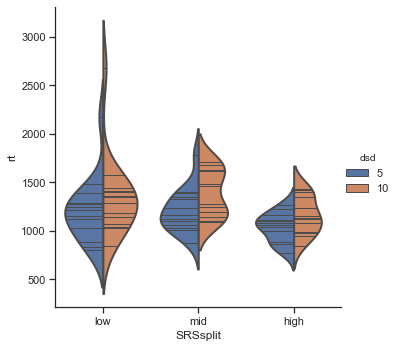

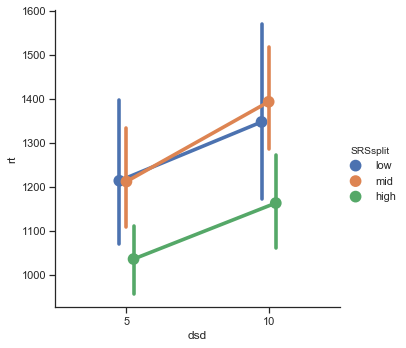

In [350]:
dfsumrtsrs = df.groupby(['SRSsplit', 'subjectId', 'dsd']).mean().reset_index()

sns.catplot(x="SRSsplit", y="rt", hue="dsd", kind="violin", split=True, inner="stick", data=dfsumrtsrs);
sns.catplot(x="dsd", y="rt", hue="SRSsplit", kind="point",dodge=.1, data=dfsumrtsrs);

This suggests some of the improved/faster visual search (found in other studies) is present here as well, at least for those with high autism traits (SRS & SP; not UI). Note that the variability in SRS in the TD group is smaller, which is to be expected (usual cutoff in 75). 


## Structural priors: oblique effect?

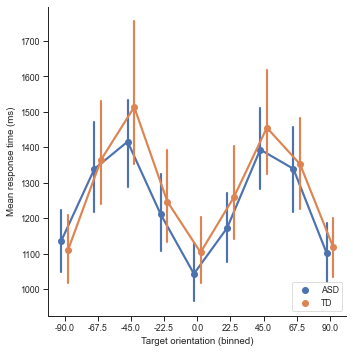

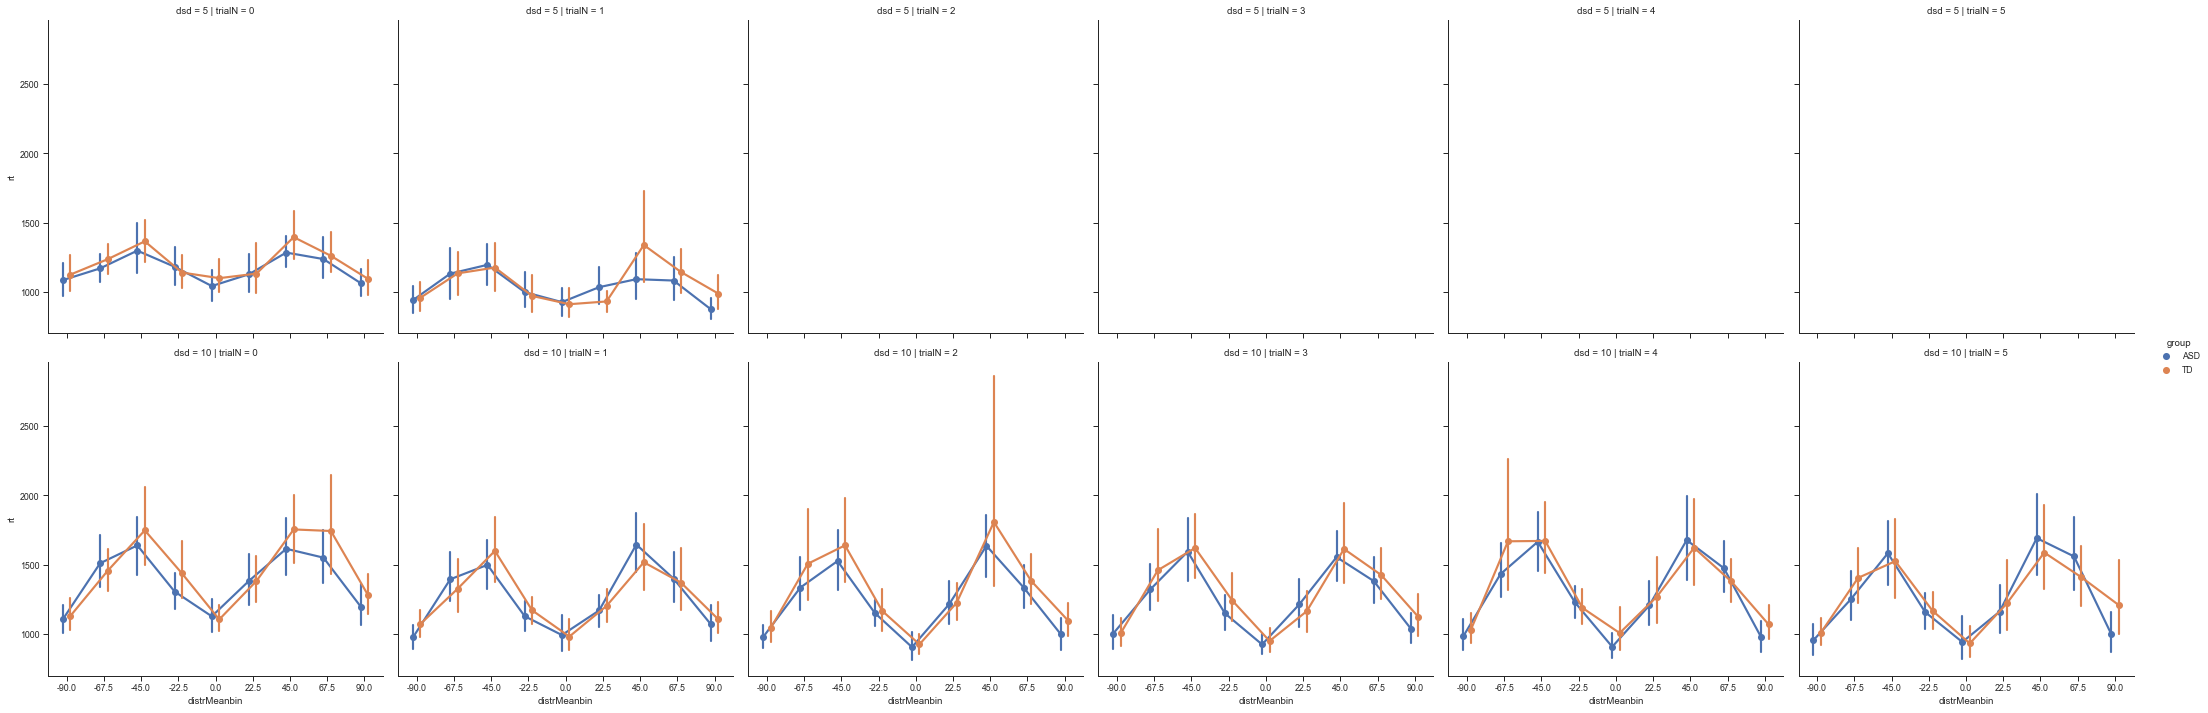

In [28]:


df['toribin']=pd.qcut(df.targetOri, 9,np.linspace(-90,90, 9) )
df['distrMeanbin']=pd.qcut(df.distrMean,9, np.linspace(-90,90, 9))
sns.set_context("paper") # seaborn function to make plots according to purpose (talk, paper, poster, notebook)

g = sns.catplot(x="toribin", y="rt", hue="group",units='subjectId', kind="point",dodge=.2, data=df[(df.correct==1)], legend=False);
g.set(xlabel='Target orientation (binned)', ylabel='Mean response time (ms)')
plt.legend(loc='lower right')
g.savefig('rtbytargetori.png', dpi=300)

sns.catplot(x="distrMeanbin", y="rt", hue="group",col='trialN',row='dsd', units='subjectId', kind="point",dodge=.2, data=df[(df.correct==1)]);

# Response Time Distributional Analyses

Some of the text and code below is copied from [Erik Marsja](https://www.marsja.se/response-time-distributions-using-python/)

Balota, D. a., & Yap, M. J. (2011). Moving Beyond the Mean in Studies of Mental Chronometry: The Power of Response Time Distributional Analyses. Current Directions in Psychological Science, 20(3), 160–166. http://doi.org/10.1177/0963721411408885

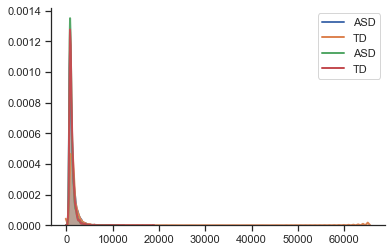

In [352]:
fig, ax = plt.subplots()
groups = ['ASD', 'TD']

for group in groups:
    condition_data = df[(df['group'] == group) & (df['correct']==1) & (df.dsd==10)]['rt']
    sns.kdeplot(condition_data, shade=True, label=group)
    
sns.despine()

for group in groups:
    condition_data = df[(df['group'] == group) & (df['correct']==1) & (df.dsd==5)]['rt']
    sns.kdeplot(condition_data, shade=True, label=group)
    
sns.despine()

Note the imbalance in datapoints, inherent to the design. Much more datapoints for dsd=10

In [51]:
print(df[(df.correct==1)].groupby(['group','dsd']).rt.count())

group  dsd
ASD    5       4408
       10     15032
TD     5       4379
       10     15293
Name: rt, dtype: int64


## Cumulative distribution function of rts

In [11]:
def cdf(df, conditions=['congruent', 'incongruent']):

    data = {i: df[(df.dsd == conditions[i])] for i in range(len(
        conditions))}
    plot_data = []

    for i, condition in enumerate(conditions):

        rt = data[i].rt.sort_values()
        yvals = np.arange(len(rt)) / float(len(rt))

        # Append it to the data
        cond = [condition]*len(yvals)

        df = pd.DataFrame(dict(dens=yvals, dv=rt, condition=cond))
        plot_data.append(df)

    plot_data = pd.concat(plot_data, axis=0)

    return plot_data

In [12]:
def cdf_plot(cdf_data, save_file=False, legend=True):
    sns.set_style('white')
    sns.set_style('ticks')
    g = sns.FacetGrid(cdf_data, hue="condition", size=8)
    g.map(plt.plot, "dv", "dens", alpha=.7, linewidth=1)
    if legend:
        g.add_legend(title="dsd")
    g.set_axis_labels("Response Time (ms)", "Probability")
    g.fig.suptitle('Cumulative density functions')

    if save_file:
        g.savefig("cumulative_density_functions_seaborn_python_response"
                  "-time.png")

    plt.show()

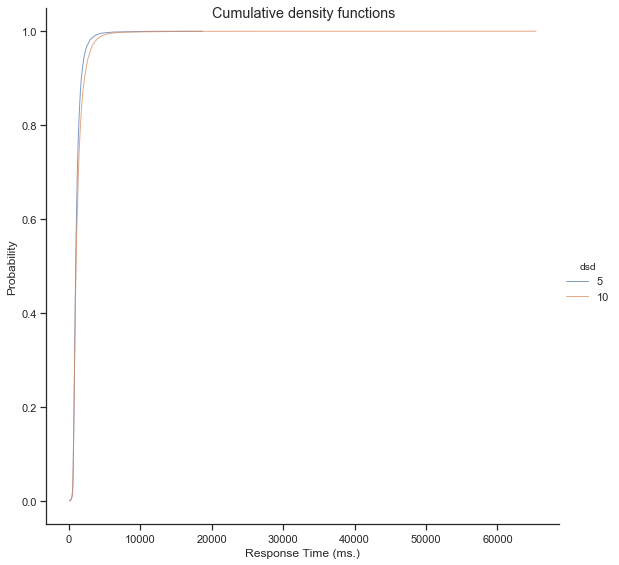

In [355]:
cdf_dat = cdf(df[(df.correct==1) ], conditions=[5,10])
cdf_plot(cdf_dat, legend=True, save_file=False)

## Conditional Accuracy Functions

Conditional accuracy functions (CAF) is a technique that also incorporates the accuracy in the task. Creating CAFs involve binning your data (e.g., the response time and accuracy) and creating a linegraph. Briefly, CAFs can capture patterns related to speed/accuracy trade-offs (see Richard, 2014).

Richard, P. (2014). The speed-accuracy tradeoff : history , physiology , methodology , and behavior. Frontiers in Neuroscience, 8(June), 1–19. http://doi.org/10.3389/fnins.2014.00150

In [13]:
def calc_caf(df, subid, rt, acc, condition, quantiles=[0.25, 0.50, 0.75, 1]):
    """
    Calculates conditional accuracy functions (CAF) per subject and agregates into 
    one CAF. 
    
    Parameters
    ----------
    df : pandas dataframe
        A subset containing the data from one of the conditions
    subid : string
        Contains the colum name with the subject identifier
    rt : string 
        column name for column containing the response/reaction times
    acc : string  
        column name for column containing the accuracy data
    condition :string 
        column name for column containing the conditions identfiers
    quantiles: list 
        contains the quantiles (e.g., [0.25, 0.50, 0.75, 1])

    Returns
    -------
        a multi-indexed pandas data frame

    Examples:
     incongr = frame[(frame.TrialType == 'incongruent)]
     incongr_caf = calc_caf(incongr, "SubID", "RT", "ACC", "incongruent")
    """

    # Subjects
    subjects = pd.Series(df[subid].values.ravel()).unique().tolist()
    subjects.sort()

    # Multi-index frame for data:
    arrays = [np.array(['rt'] * len(quantiles) + ['acc'] * len(quantiles)),
              np.array(quantiles * 2)]

    data_caf = pd.DataFrame(columns=subjects, index=arrays)

    # Calculate CAF for each subject
    for subject in subjects:

        sub_data = df.loc[(df[subid] == subject)]

        subject_cdf = sub_data[rt].quantile(q=quantiles).values

        # calculate mean response time and proportion of error for each bin
        for i, q in enumerate(subject_cdf):

            quantile = quantiles[i]

            # First quantile
            if i < 1:
                # Subset
                temp_df = sub_data[(sub_data[rt] < subject_cdf[i])]
                # RT
                data_caf.loc[('rt', quantile)][subject] = temp_df[rt].mean()
                # Accuracy
                data_caf.loc[('acc', quantile)][subject] = temp_df[acc].mean()

            # Second  & third quantile
            elif i == 1 or i < len(quantiles):

                # Subset
                temp_df = sub_data[(sub_data[rt] > subject_cdf[i - 1]) & (
                    sub_data[rt] < q)]
                # RT
                data_caf.loc[('rt', quantile)][subject] = temp_df[rt].mean()

                # Accuracy
                data_caf.loc[('acc', quantile)][subject] = temp_df[acc].mean()

            # Last quantile MAY WANT TO CHANGE THIS
            elif i == len(quantiles):
                # Subset
                temp_df = sub_data[(sub_data[rt] > subject_cdf[i])]

                # RT
                data_caf.loc[('rt', quantile)][subject] = temp_df[rt].mean()

                # Accuracy
                data_caf.loc[('acc', quantile)][subject] = temp_df[acc].mean()

    # Aggregate subjects CAFs
    data_caf = data_caf.mean(axis=1).unstack(level=0)

    # Add trialtype
    data_caf['trialtype'] = [condition for _ in range(len(quantiles))]

    return data_caf


def caf_plot(df, save_file=False, im_size=6):
    """
    Plotting the conditional accuracy functions (CAF)
    
    Parameters
    ----------
    df : pandas dataframe 
        containing the CAF(s) calculated with calc_caf
    save_file : boolean
        True if planning to save file
    im_size : integer
        Size of the image (i.e., the plot)
        
    Examples
    --------
    incongr = frame[(frame.TrialType == 'incongruent)]
    incongr_caf = calc_caf(incongr, "SubID", "RT", "ACC", "incongruent")
    caf_plot(incongr_caf)
    """
    sns.set_style('white')
    sns.set_style('ticks')

    g = sns.FacetGrid(df, hue="trialtype", size=im_size, ylim=(0, 1.1))
    g.map(plt.scatter, "rt", "acc", s=50, alpha=.7, linewidth=1,
          edgecolor="white")
    g.map(plt.plot, "rt", "acc", alpha=.7, linewidth=1)
    g.add_legend(title="", labels=['low SRS', 'mid SRS', 'high SRS'])
    g.set_axis_labels("Response Time (ms)", "Accuracy")
    #g.fig.suptitle('Conditional Accuracy Functions')
    plt.ylim(.5, 1)


    if save_file:
        g.savefig("CAFsrs.png",dpi=300)
    
    plt.show()




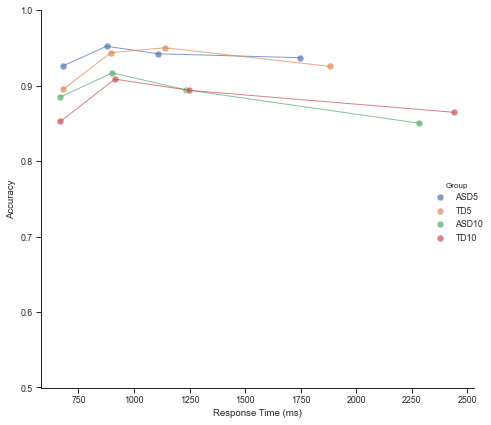

In [140]:
# Conditional accuracy function (data) for incongruent and congruent conditions
ASD5 = calc_caf(df[(df.group == "ASD") & (df.dsd == 5)], "subjectId", "rt", "correct",
               "ASD5")
TD5 = calc_caf(df[(df.group == "TD") & (df.dsd == 5)], "subjectId", "rt", "correct",
               "TD5")
ASD10 = calc_caf(df[(df.group == "ASD") & (df.dsd == 10)], "subjectId", "rt", "correct",
               "ASD10")
TD10 = calc_caf(df[(df.group == "TD") & (df.dsd == 10)], "subjectId", "rt", "correct",
               "TD10")


#Combine the data and plot it
df_caf = pd.concat([ASD5, TD5, ASD10, TD10])

caf_plot(df_caf)

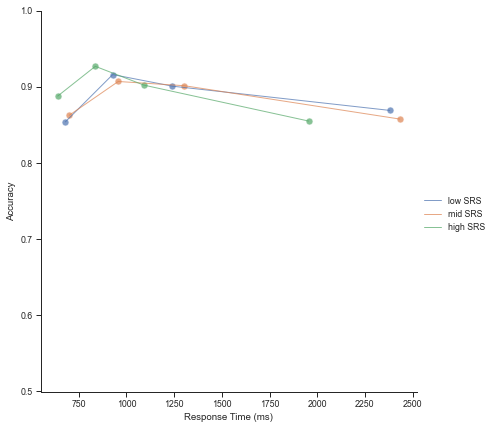

In [21]:
# Conditional accuracy function (data) for incongruent and congruent conditions
low = calc_caf(df[(df.SRSsplit == "low")], "subjectId", "rt", "correct",
               "low")
high = calc_caf(df[(df.SRSsplit == "high")], "subjectId", "rt", "correct",
               "high")
mid = calc_caf(df[(df.SRSsplit == "mid")], "subjectId", "rt", "correct",
               "mid")


#Combine the data and plot it
df_caf = pd.concat([low,mid, high])

caf_plot(df_caf, True)



In [110]:
print(df.rt.quantile(.20))

print(df[df.rt<df.rt.quantile(.20)].groupby(['group']).rt.count())

# model formulation
fml = "correct ~ SRSsplit * dsd"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subjectId", df[df.rt<df.rt.quantile(.25)], cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())


725.9882966172
group
ASD    4446
TD     4231
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                     correct   No. Observations:                 8997
Model:                                 GEE   No. clusters:                       42
Method:                        Generalized   Min. cluster size:                  22
                      Estimating Equations   Max. cluster size:                 552
Family:                           Binomial   Mean cluster size:               214.2
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                      do, 23 apr 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         14:31:27
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

## Delta plots

Delta plots (DPs) can be used to visualize and compare response time quantiles obtained under two experimental conditions. DPs enable examination whether the experimental manipulation has a larger effect on the relatively fast responses or on the relatively slow ones (e.g., Speckman, Rouder, Morey, & Pratte, 2008).

Speckman, P. L., Rouder, J. N., Morey, R. D., & Pratte, M. S. (2008). Delta Plots and Coherent Distribution Ordering. The American Statistician, 62(3), 262–266. http://doi.org/10.1198/000313008X333493

In [47]:
def calc_delta_data(df, subid, rt, condition, conditions=['incongruent',
                                                   'congruent']):
    """
    Calculating the data for creating delta plots. That is, binning
    the response time and accuracy data in deciles. First each subjects
    data is binned. Then the binned data is avaraged.
    
    Parameters
    ----------
    df : pandas dataframe
        Data to bin.
    subid : string
        Column name for column with the subject identfier
    rt : string
        Column name for column with the response times
    condition : string
        Column name for column with the conditions
    conditions : list
        Containing string of the conditions in the experiment
        
    Returns
    -------
    delta_data: Dataframe
        Binned avarage response time and response time diff b/w conditions 
        
    Examples
    --------
    d = calc_delta_data(frame, "SubID", "RT", "TrialType", ['incongruent',
                                                       'congruent'])
    
    """


    subjects = pd.Series(df[subid].values.ravel()).unique().tolist()
    subjects.sort()

    deciles = np.arange(0.1, 1., 0.1)

    cond_one = conditions[0]
    cond_two = conditions[1]

    # Frame to store the data (per subject)
    arrays = [np.array([cond_one, cond_two]).repeat(len(deciles)),
              np.array(deciles).tolist() * 2]
    data_delta = pd.DataFrame(columns=subjects, index=arrays)

    for subject in subjects:

        sub_data_inc = df.loc[(df[subid] == subject) & (df[condition] ==
                                                        cond_one)]
        sub_data_con = df.loc[(df[subid] == subject) & (df[condition] ==
                                                        cond_two)]

        inc_q = sub_data_inc[rt].quantile(q=deciles).values
        con_q = sub_data_con[rt].quantile(q=deciles).values
        for i, dec in enumerate(deciles):
            data_delta.loc[(cond_one, dec)][subject] = inc_q[i]
            data_delta.loc[(cond_two, dec)][subject] = con_q[i]


    # Aggregate deciles
    data_delta = data_delta.mean(axis=1).unstack(level=0)
    # Calculate difference
    data_delta['Diff'] = data_delta[cond_one] - data_delta[cond_two]
    # Calculate average
    data_delta['Average'] = (data_delta[cond_one] + data_delta[cond_two]) / 2

    return data_delta


def delta_plot(delta_data, group=None, save_file=False, im_size=6):
    """
    Delta plot
    
    Parameters
    ----------
    delta_data : pandas dataframe
        Binned avarage response time and response time diff b/w conditions 
    save_file : boolean
        True if file (.png) of plot is going to be saved
    im_size : integer
        Size of the image (i.e., the plot)
        
    Examples
    -------
    d = calc_delta_data(frame, "SubID", "RT", "TrialType", ['incongruent',
                                                       'congruent'])
    delta_plot(d, save_file=True)
    """

    ymax = delta_data['Diff'].max() + 10
    ymin = delta_data['Diff'].min() - 10
    xmin = delta_data['Average'].min() - 20
    xmax = delta_data['Average'].max() + 20

    g = sns.FacetGrid(delta_data, hue=group, ylim=(ymin, ymax), xlim=(xmin, xmax),
                      size=im_size)
    g.map(plt.scatter, "Average", "Diff", s=50, alpha=.7, linewidth=1,
          edgecolor="white")
    g.map(plt.plot, "Average", "Diff", alpha=.7, linewidth=1)
    ax = g.axes[0]
    ax[0].axhline(0, ls='--', color='black')
    g.set_axis_labels("Mean response time (ms)", "Effect (ms)")
    if group: g.add_legend(title=group)
    #g.fig.suptitle('Delta Plot')
    # if save_file:
    g.savefig("delta_plot_seaborn_python_response-time.png")
    

Usually applied on within-subject variable, but also applicable here?

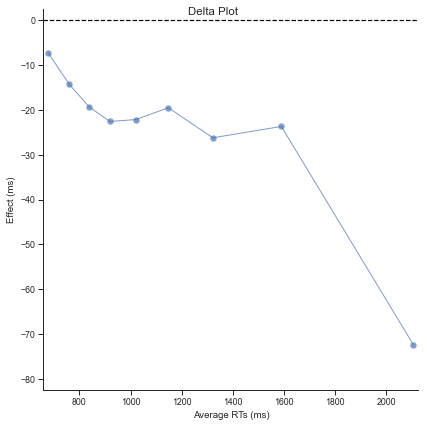

In [114]:
d_data = calc_delta_data(df[(df.correct==1)], "subjectId", "rt", "group", ['ASD','TD'])
delta_plot(d_data)

We see a reversal of the effect. ASD is faster for the short RTs (consistent with earlier work on visual search in ASD), but slower in the higher RTs.

> "If all decile classes have faster mean in one group than in the other, we say that there is coherent mean ordering and that one group stochastically dominates the other in mean... Violations of coherent orderings of mean are diagnostic signatures of complex effects (such as the presence of multiple processes or mixtures) and suggest further avenues of study." (Speckman et al. 2008)

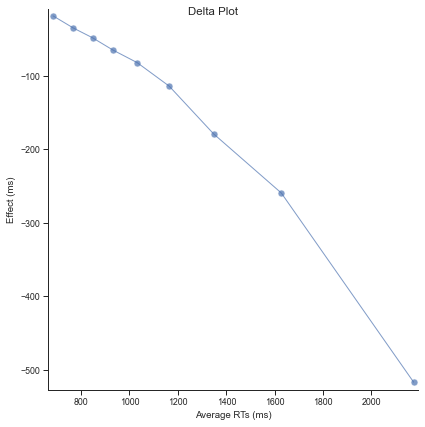

In [115]:
d_data = calc_delta_data(df[(df.correct==1)], "subjectId", "rt", "SPsplit", ['high','low'])
delta_plot(d_data)

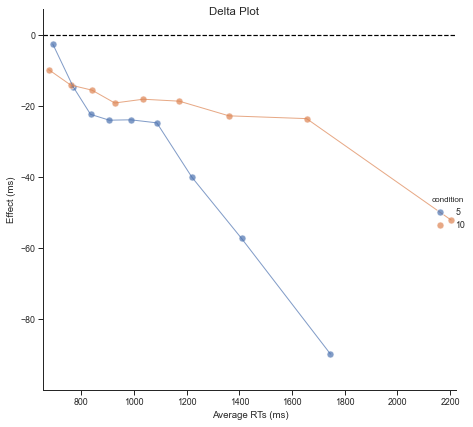

In [116]:
# Calculate delta plot data and plot it
d_data5 = calc_delta_data(df[(df.correct==1) & (df.dsd == 5)], "subjectId", "rt", "group", ['ASD','TD'])
d_data5['condition']=5
d_data10 = calc_delta_data(df[(df.correct==1) & (df.dsd == 10)], "subjectId", "rt", "group", ['ASD','TD'])
d_data10['condition']=10

d_data = pd.concat([d_data5, d_data10])
delta_plot(d_data, group='condition')

ASD is consistently but slightly better across the board in the low variability condition. However, in the high variability condition we see the reversal. This might explain the lack of main effect of group in the linear model. 

In [27]:
print(df.rt.quantile(.5))

print(df[df.rt<df.rt.quantile(.5)].groupby(['group']).rt.count())

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ group * dsd", groups="subjectId",data=df[(df.rt>df.rt.quantile(.5)) & (df.correct==1)], family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())
print(result1.cov_struct.summary())

996.7658626265
group
ASD    10677
TD     10453
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                18841
Model:                                 GEE   No. clusters:                       48
Method:                        Generalized   Min. cluster size:                 141
                      Estimating Equations   Max. cluster size:                 652
Family:                           Gaussian   Mean cluster size:               392.5
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                      vr, 27 sep 2019   Scale:                      398804.766
Covariance type:                    robust   Time:                         17:23:59
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Interc

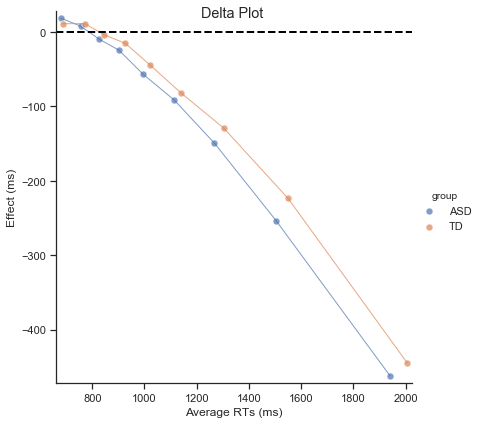

In [370]:
# Calculate delta plot data and plot it
d_dataASD = calc_delta_data(df[(df.correct==1) & (df.group == 'ASD')], "subjectId", "rt", "dsd", [5,10])
d_dataASD['group']='ASD'
d_dataTD = calc_delta_data(df[(df.correct==1) & (df.group == 'TD')], "subjectId", "rt", "dsd", [5,10])
d_dataTD['group']='TD'
d_data = pd.concat([d_dataASD, d_dataTD])

delta_plot(d_data, group='group')

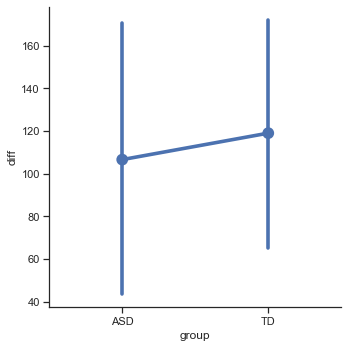

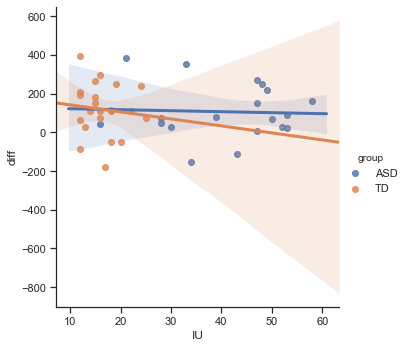

In [371]:
dfdsdsum =  df.query("previous_correct==1 & correct==1").groupby(['group','subjectId', 'dsd']).mean().reset_index()

dsddiff = dfdsdsum.pivot_table(index=['group','subjectId','IU'],columns='dsd',values='rt').reset_index()

dsddiff['diff']= dsddiff[10] - dsddiff[5]



g = sns.catplot(x="group", y="diff", units='subjectId', kind="point", data=dsddiff, dodge=.2);


sns.lmplot(x="IU", y="diff", hue="group", data=dsddiff);

# Check evolution of rts over learning and test phase

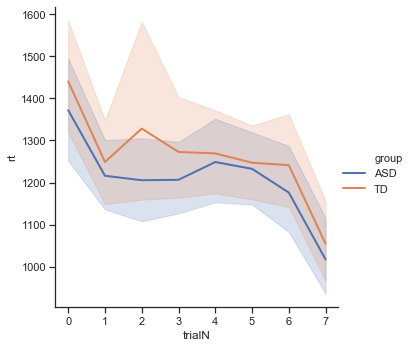

In [372]:
dfsumtrials = df.query('correct==1 & previous_correct==1').groupby(['subjectId', 'group','dsd', 'trialN']).rt.mean().reset_index()

dfsumtrials.trialN[(dfsumtrials.dsd==5) & (dfsumtrials.trialN==0)]=6
dfsumtrials.trialN[(dfsumtrials.dsd==5) & (dfsumtrials.trialN==1)]=7
sns.relplot(x="trialN", y="rt", hue="group", kind="line", data=dfsumtrials);

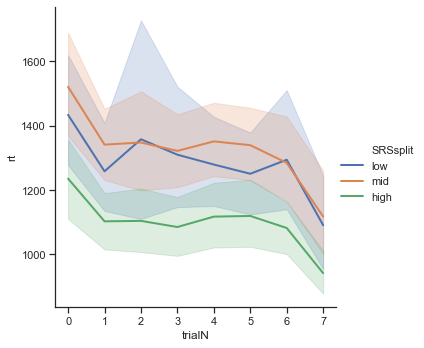

In [373]:
dfsumtrials = df.query('correct==1 & previous_correct==1').groupby(['subjectId', 'SRSsplit','dsd', 'trialN']).rt.mean().reset_index()

dfsumtrials.trialN[(dfsumtrials.dsd==5) & (dfsumtrials.trialN==0)]=6
dfsumtrials.trialN[(dfsumtrials.dsd==5) & (dfsumtrials.trialN==1)]=7
sns.relplot(x="trialN", y="rt", hue="SRSsplit", kind="line", data=dfsumtrials);

# Repetition effect (learning within prime streaks)

Does repeated presentation of the same distraction distribution (learning the distraction distribution) improve detection speed, accuracy?

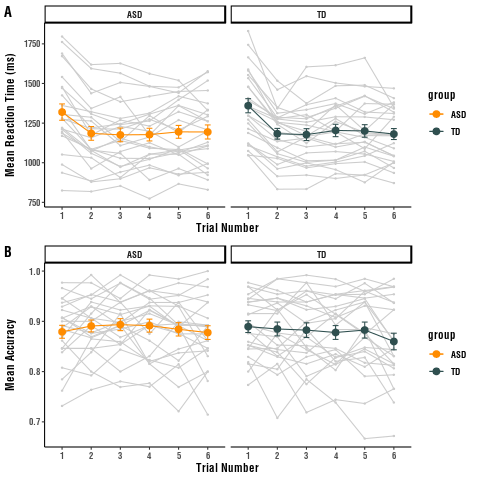

In [89]:
%%R

RT_trial <- df_filter %>%
  filter(correct==1) %>% #only correct responses
  filter(previous_correct == 1)  %>% #only when previous trial was correct (post-error slowdown)
  filter(dsd==10) %>% #prime trials
  group_by(subjectId, group, dsd,trialN) %>% 
  summarise(mean_rt=mean(rt),sd_rt=sd(rt), mean_log_rt=mean(log_rt), sd_log_rt = sd(log_rt))

#Plot RTs over trials within prime streaks
RT_repetition_plot<- ggplot(RT_trial,aes(x=as.factor(trialN),y=mean_rt, color = group)) +
geom_point(size=0.5, colour = "gray80") + #Individual data points 
geom_line(aes(group=subjectId), colour = "gray80") + #lines between individual data points
stat_summary(fun.y=base::mean, geom="point", size =3) + # points for means per group
stat_summary(fun.y=base::mean, geom="line",aes(group=group)) + #lines between points for means per group
stat_summary(fun.data = "mean_se", geom="errorbar", width = 0.2) + #Standard error errorbars
facet_grid(~group) +#Per group
xlab("Trial Number") + ylab("Mean Reaction Time (ms)") +    #axis titles
theme_classic() + 
scale_color_manual(values=c("darkorange", "darkslategrey")) + #colors
theme(plot.title = element_text(hjust = 0.5)) + # Center titles
scale_x_discrete(labels=c("0" = "1", "1" = "2", "2" = "3","3" = "4","4"= "5","5" = "6")) #Rename x-axis labels

#same for accuracy
acc_trial<- df_filter %>%
  filter(dsd== 10) %>%
  group_by(subjectId,group,trialN) %>%
  summarise(mean_acc=mean(correct),sd_acc=sd(correct))

acc_repetition_plot<-ggplot(acc_trial,aes(x=as.factor(trialN),y=mean_acc, color = group))+ geom_point(size=0.5, colour = "gray80")  + geom_line(aes(group=subjectId), colour = "gray80") + stat_summary(fun.y=base::mean, geom="point", size =3) + stat_summary(fun.y=base::mean, geom="line",aes(group=group)) + stat_summary(fun.data = "mean_se", geom="errorbar", width = 0.2) +  facet_grid(~group) +
  xlab("Trial Number") + ylab("Mean Accuracy")   + theme_classic() + scale_color_manual(values=c("darkorange", "darkslategrey"))+
  theme(plot.title = element_text(hjust = 0.5))+ scale_x_discrete(labels=c("0" = "1", "1" = "2",
                              "2" = "3","3" = "4","4"= "5","5" = "6"))

plot_grid(RT_repetition_plot, acc_repetition_plot, labels = "AUTO", align ='v', ncol=1)

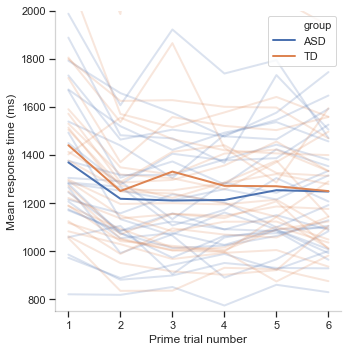

In [43]:
dfsumrep = df.query('correct==1 & previous_correct==1 & dsd==10').groupby(['subjectId', 'group', 'trialN']).rt.mean().reset_index()
g = sns.relplot(x="trialN", y="rt", hue="group", kind="line",units='subjectId', data=dfsumrep, estimator=None, legend=False);
plt.setp([g.ax.get_children()],alpha=.2)
sns.set(style="ticks", rc={"lines.linewidth": 2})
sns.lineplot(x="trialN", y="rt", hue="group",ci=None, data=dfsumrep);
g.set(ylim=[750,2000], xlabel='Prime trial number', ylabel='Mean response time (ms)')
g.set_xticklabels(labels= ['0','1','2','3','4','5','6'])
g.savefig('trialbyrt.png', dpi=300)

## Helmert contrasts comparing each level with the mean of the next levels

In [78]:
%%R


PRIME_TR <- df_filter %>%
  filter(correct==1) %>% #Only correct trials
  filter(previous_correct == 1) %>% #Previous trial correct to account for post-error slowdown
  filter(dsd==10) #Only prime trials

PRIME_TR$trialN = factor(PRIME_TR$trialN)

my.helmert = matrix(c(5,-1,-1,-1,-1,-1,0,4,-1,-1,-1,-1,0,0,3,-1,-1,-1,0,0,0,2,-1,-1,0,0,0,0,1,-1), ncol = 5) #Make my own helmert contrast matrix, because build-in version is actually reverse Helmert contrast

lmer_RT_TD<-lmer(log_rt ~ trialN * group + (1|subjectId), data= PRIME_TR,REML=F,control = lmerControl(optimizer ="Nelder_Mead"), contrasts = list(trialN = my.helmert))
summary(lmer_RT_TD)


Error in filter(., correct == 1) : object 'correct' not found


In [373]:
%%R

df_acc<- df_filter%>%
  filter(dsd== 10)%>%
  mutate(trialN = factor(trialN))

acc_trial$trialN = factor(acc_trial$trialN)

glmer_acc<-glmer(correct ~ trialN*group + (trialN|subjectId),family = binomial, data = df_acc,contrasts = list(trialN = my.helmert))
summary(glmer_acc)

R[write to console]: Error in factor(acc_trial$trialN) : object 'acc_trial' not found

R[write to console]: In addition: 
R[write to console]: There were 12 warnings (use warnings() to see them)
R[write to console]: 




Error in factor(acc_trial$trialN) : object 'acc_trial' not found


A quick decrease in reaction times after one trial with distractors sampled from the same Gaussian distribution in both groups (no difference between groups) and no change in average accuracy over trial number. Little additional learning after second trial in streak. 

# Transition from prime to probe sequence

group  transprime
ASD    0.0           2407
       1.0           2526
TD     0.0           2448
       1.0           2553
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                 9934
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                 132
                      Estimating Equations   Max. cluster size:                 253
Family:                           Gaussian   Mean cluster size:               202.7
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                      di, 02 jun 2020   Scale:                      625983.206
Covariance type:                    robust   Time:                         17:43:23
                             coef    std err          z      P>|z|      [0.025      0.975]
--------

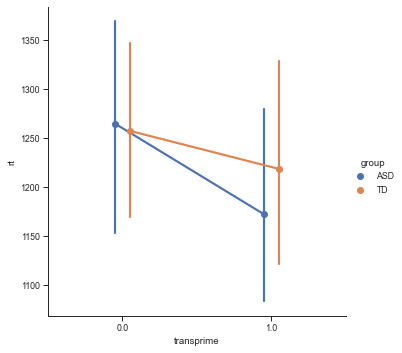

In [14]:

dfDL = df[((df.transprime==0) | (df.transprime==1)) & (df.correct==1) & (df.previous_correct == 1)]
print(dfDL.groupby(['group','transprime']).rt.count())
sns.catplot(x="transprime", y="rt", hue="group", units='subjectId', kind="point",dodge=.1, data=dfDL);

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ transprime * group", groups="subjectId",data=dfDL, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())
print(result1.cov_struct.summary())

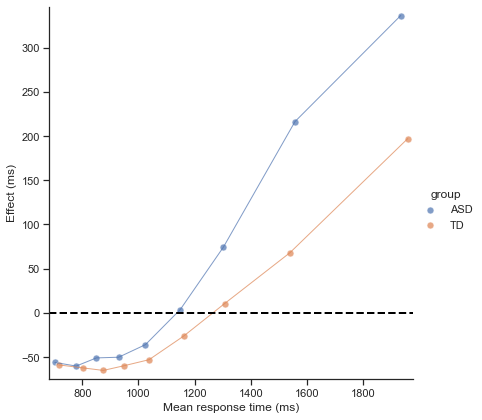

In [48]:
# Calculate delta plot data and plot it
d_dataASD = calc_delta_data(dfDL[(dfDL.group == 'ASD')], "subjectId", "rt", "transprime", [0,1])
d_dataASD['group']='ASD'
d_dataTD = calc_delta_data(dfDL[(dfDL.group == 'TD')], "subjectId", "rt", "transprime", [0,1])
d_dataTD['group']='TD'
d_data = pd.concat([d_dataASD, d_dataTD])
delta_plot(d_data, group='group')

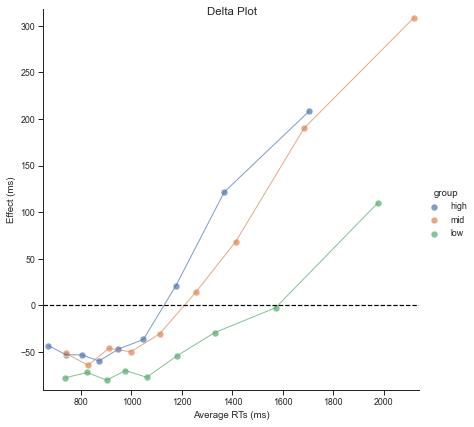

In [16]:
# Calculate delta plot data and plot it
d_datalow = calc_delta_data(dfDL[(dfDL.SRSsplit == 'high')], "subjectId", "rt", "transprime", [0,1])
d_datalow['group']='high'
d_datahigh = calc_delta_data(dfDL[(dfDL.SRSsplit == 'low')], "subjectId", "rt", "transprime", [0,1])
d_datahigh['group']='low'
d_datamid = calc_delta_data(dfDL[(dfDL.SRSsplit == 'mid')], "subjectId", "rt", "transprime", [0,1])
d_datamid['group']='mid'

d_data = pd.concat([d_datalow,d_datamid, d_datahigh])
delta_plot(d_data, group='group')

In [72]:
print(dfDL.groupby(['group','transprime']).rt.mean())
print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group','transprime']).rt.mean())
print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group','transprime']).rt.mean())
print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group','transprime', 'in_range']).rt.mean())
print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group','transprime', 'in_range']).rt.count())

group  transprime
ASD    0.0           1208.285223
       1.0           1149.253689
TD     0.0           1199.547517
       1.0           1178.897397
Name: rt, dtype: float64
group  transprime
ASD    0.0           764.819997
       1.0           800.622010
TD     0.0           773.967188
       1.0           806.754692
Name: rt, dtype: float64
group  transprime
ASD    0.0           764.819997
       1.0           800.622010
TD     0.0           773.967188
       1.0           806.754692
Name: rt, dtype: float64
group  transprime  in_range
ASD    0.0         in          755.899929
                   out         769.696597
       1.0         in          825.354496
                   out         783.587714
TD     0.0         in          774.209901
                   out         773.859283
       1.0         in          828.479796
                   out         791.516082
Name: rt, dtype: float64
group  transprime  in_range
ASD    0.0         in          439
                   out         

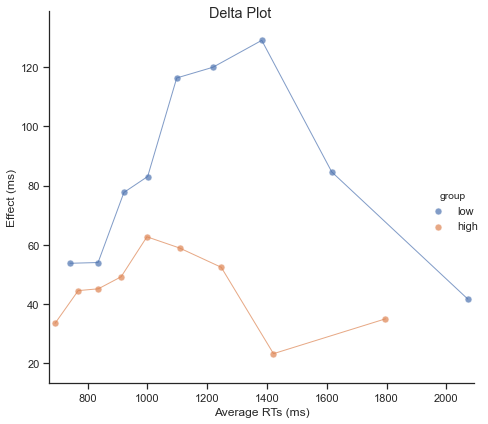

In [210]:
# Calculate delta plot data and plot it
d_datalow = calc_delta_data(dfDL[(dfDL.IUsplit == 'low')], "subjectId", "rt", "in_range", ['in','out'])
d_datalow['group']='low'
d_datahigh = calc_delta_data(dfDL[(dfDL.IUsplit == 'high')], "subjectId", "rt", "in_range", ['in','out'])
d_datahigh['group']='high'
#d_datamid = calc_delta_data(dfDL[(dfDL.SRSsplit == 'mid')], "subjectId", "rt", "transprime", [0,1])
#d_datamid['group']='mid'

d_data = pd.concat([d_datalow, d_datahigh])
delta_plot(d_data, group='group')

In [20]:

print(dfDL.rt.quantile(.5))

print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group']).rt.count())

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ transprime * group * in_range", groups="subjectId",data=dfDL[(dfDL.rt<dfDL.rt.quantile(.5))], family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())
print(result1.cov_struct.summary())

1016.1024848249999
group
ASD    2538
TD     2429
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                 4967
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                  22
                      Estimating Equations   Max. cluster size:                 181
Family:                           Gaussian   Mean cluster size:               101.4
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                      di, 02 jun 2020   Scale:                       18606.752
Covariance type:                    robust   Time:                         17:56:30
                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [17]:
dfDL[(dfDL.rt<dfDL.rt.quantile(.5))].to_csv('dfdl.csv')

In [18]:
%%R

dfdl <- suppressMessages(read_csv('dfdl.csv'))

##linear mixed model with DV = RT, IV within = dsd
lmer_rt<-lmer(log_rt ~ in_range * group * transprime + (1|subjectId), REML=F,control = lmerControl(optimizer ="Nelder_Mead"),  data = dfdl[which(dfdl$correct==1), ])
print(summary(lmer_rt))

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log_rt ~ in_range * group * transprime + (1 | subjectId)
   Data: dfdl[which(dfdl$correct == 1), ]
Control: lmerControl(optimizer = "Nelder_Mead")

     AIC      BIC   logLik deviance df.resid 
 -2904.4  -2839.3   1462.2  -2924.4     4957 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.0215 -0.5902  0.0900  0.7171  2.1636 

Random effects:
 Groups    Name        Variance Std.Dev.
 subjectId (Intercept) 0.004192 0.06475 
 Residual              0.031672 0.17797 
Number of obs: 4967, groups:  subjectId, 49

Fixed effects:
                                 Estimate Std. Error         df t value
(Intercept)                      -0.28311    0.01575   81.90892 -17.971
in_rangeout                       0.02280    0.01058 4926.91935   2.155
groupTD                           0.01720    0.02242   87.34548   0.767
transprime                        0.09943    0.01158 4932.1

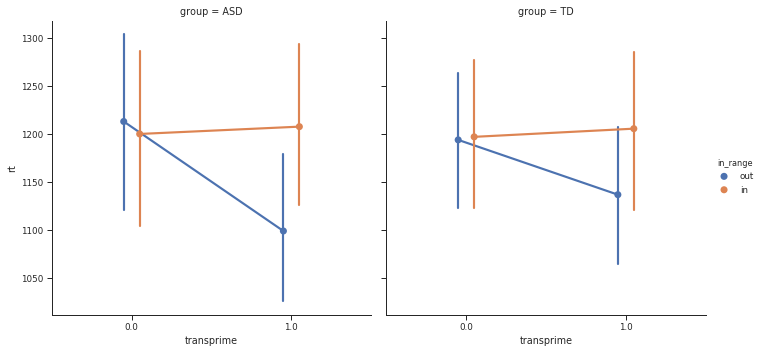

In [30]:
sns.catplot(x="transprime", y="rt", hue="in_range", col='group', units='subjectId', kind="point",dodge=.1, data=dfDL);


### Interim conclusion
There's an effect of transition from prime to probe trials in the lower half and higher half of rts, but it is reversed. People are slower after switch in the short reaction times (because of target that is in old distractor dist range?), but faster after switch in the long reaction times (because lower dsd?).

## Accuracy

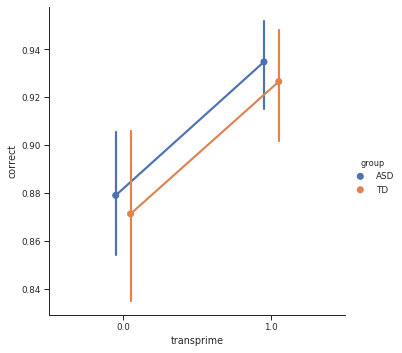

In [31]:
sns.catplot(x="transprime", y="correct", hue="group", units='subjectId', kind="point",dodge=.1, data=df);

In [32]:
# model formulation
fml = "correct ~ transprime * group"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subjectId", df, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                     correct   No. Observations:                12113
Model:                                 GEE   No. clusters:                       48
Method:                        Generalized   Min. cluster size:                 245
                      Estimating Equations   Max. cluster size:                 258
Family:                           Binomial   Mean cluster size:               252.4
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Tue, 24 Sep 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         13:53:17
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.9850      0.111     17.860      0

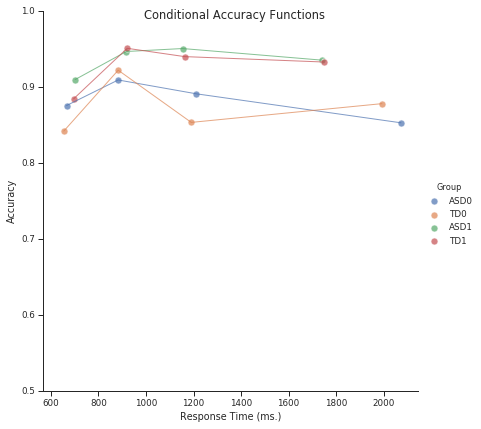

In [35]:

# Conditional accuracy function (data) for incongruent and congruent conditions
ASD0 = calc_caf(df[(df.group == "ASD") & (df.transprime == 0)], "subjectId", "rt", "correct",
               "ASD0")
TD0 = calc_caf(df[(df.group == "TD") & (df.transprime == 0)], "subjectId", "rt", "correct",
               "TD0")
ASD1 = calc_caf(df[(df.group == "ASD") & (df.transprime == 1)], "subjectId", "rt", "correct",
               "ASD1")
TD1 = calc_caf(df[(df.group == "TD") & (df.transprime == 1)], "subjectId", "rt", "correct",
               "TD1")


#Combine the data and plot it
df_caf = pd.concat([ASD0, TD0, ASD1, TD1])

caf_plot(df_caf)

# Transition from probe to prime sequence

group  transprobe
ASD    0.0           2438
       1.0           2369
TD     0.0           2480
       1.0           2445
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                 9732
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                 133
                      Estimating Equations   Max. cluster size:                 238
Family:                           Gaussian   Mean cluster size:               198.6
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                      do, 23 jan 2020   Scale:                      621440.651
Covariance type:                    robust   Time:                         16:24:32
                             coef    std err          z      P>|z|      [0.025      0.975]
--------

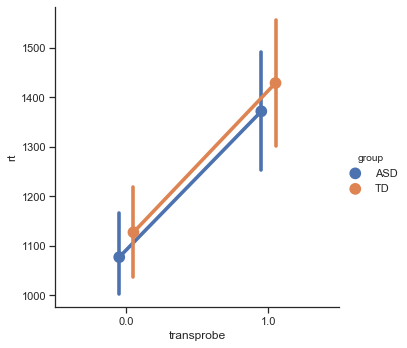

In [384]:
dfDL = df[((df.transprobe==0) | (df.transprobe==1)) & (df.correct==1) & (df.previous_correct == 1)]
#check nb of trials
print(dfDL.groupby(['group','transprobe']).rt.count())

sns.catplot(x="transprobe", y="rt", hue="group", units='subjectId', kind="point",dodge=.1, data=dfDL);

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ transprobe * group", groups="subjectId",data=dfDL, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

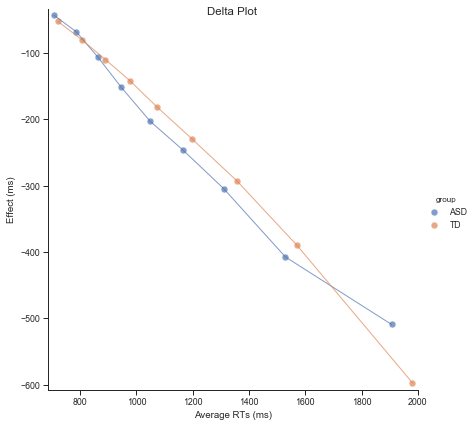

In [477]:
# Calculate delta plot data and plot it
d_dataASD = calc_delta_data(dfDL[(dfDL.group == 'ASD')], "subjectId", "rt", "transprobe", [0,1])
d_dataASD['group']='ASD'
d_dataTD = calc_delta_data(dfDL[(dfDL.group == 'TD')], "subjectId", "rt", "transprobe", [0,1])
d_dataTD['group']='TD'
d_data = pd.concat([d_dataASD, d_dataTD])

delta_plot(d_data, group='group')

# Learning within probe trials?

Note that only part of the sequences have 2 probe trials.

group  trialN
ASD    0         2561
       1         1398
TD     0         2590
       1         1349
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                 7898
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                  95
                      Estimating Equations   Max. cluster size:                 194
Family:                           Gaussian   Mean cluster size:               161.2
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                      di, 07 jan 2020   Scale:                      260799.757
Covariance type:                    robust   Time:                         17:32:15
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

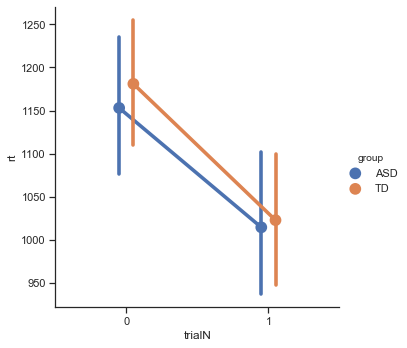

In [117]:
dfDL = df[((df.trialN==0) | (df.trialN==1)) & (df.dsd==5) & (df.correct==1) & (df.previous_correct == 1)]
print(dfDL.groupby(['group','trialN']).rt.count())
sns.catplot(x="trialN", y="rt", hue="group", units='subjectId', kind="point",dodge=.1, data=dfDL);

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ trialN * group", groups="subjectId",data=dfDL, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

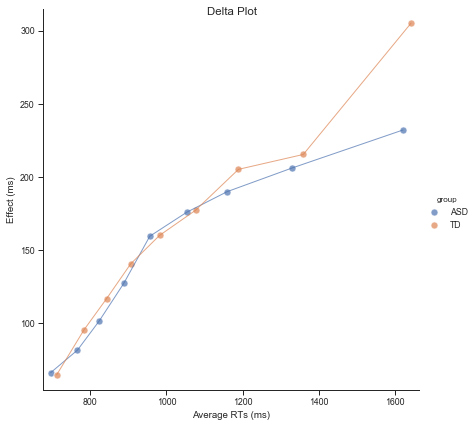

In [483]:
# Calculate delta plot data and plot it
d_dataASD = calc_delta_data(dfDL[(dfDL.group == 'ASD')], "subjectId", "rt", "trialN", [0,1])
d_dataASD['group']='ASD'
d_dataTD = calc_delta_data(dfDL[(dfDL.group == 'TD')], "subjectId", "rt", "trialN", [0,1])
d_dataTD['group']='TD'
d_data = pd.concat([d_dataASD, d_dataTD])

delta_plot(d_data, group='group')

# Inter-trial priming by target orientation within prime streaks

During each prime streak, the distribution from which the distractors were sampled remained the same. However, target orientation switched randomly within each prime streak. Therefore, we can assess inter-trial priming by the previous target orientation by analyzing reaction times on a trial as a function of the difference between the current target orientation and the previous target orientation (CT-PT).

R[write to console]: `geom_smooth()` using formula 'y ~ x'



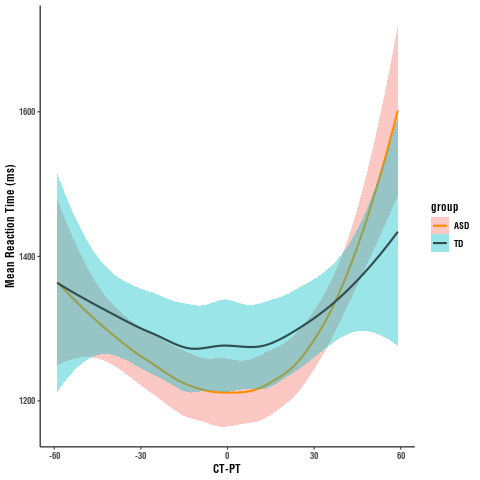

In [212]:
%%R

df_rt_ctpt_prime<- df_filter %>%
  filter(correct==1) %>%
  filter(dsd==10)%>%
  filter(trialN > 0) #not the first trial

df_rt_ctpt_prime %>%
  group_by(subjectId,group,ctpt) %>% #Rt for each ctpt per participant
  summarise(rt=mean(rt)) %>%
  ggplot(aes(ctpt,rt, color=group))  +geom_smooth(method='loess', aes(fill=group)) + theme_classic()+ scale_color_manual(values=c("darkorange", "darkslategrey"))+ xlab("CT-PT") + ylab("Mean Reaction Time (ms)") 
    

R[write to console]: `geom_smooth()` using formula 'y ~ x'



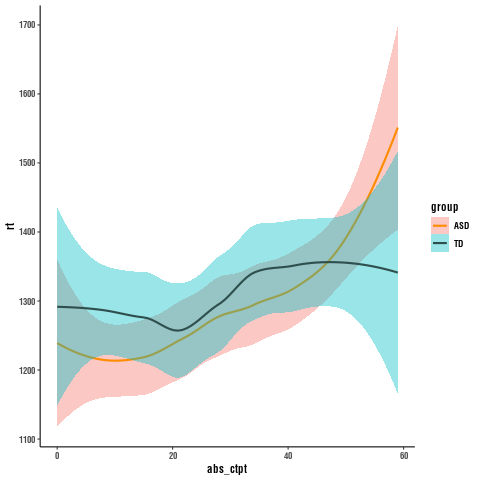

In [213]:
%%R

# Absolute ctpt:
df_rt_ctpt_prime %>%
  group_by(subjectId,group,abs_ctpt) %>%
  summarise(rt=mean(rt)) %>%
  ggplot(aes(abs_ctpt,rt, color=group)) + geom_smooth(method='loess', aes(fill=group))  + theme_classic()+ scale_color_manual(values=c("darkorange", "darkslategrey"))

In [216]:
%%R

#Absolute difference between current target and previous target as predictor
lmer_rt_ctpt1 <- lmer(log_rt~ abs_ctpt_z*group + (abs_ctpt_z|subjectId),REML=F,control = lmerControl(optimizer ="Nelder_Mead"),  data=df_rt_ctpt_prime)
summary(lmer_rt_ctpt1)

#Difference between current target and previous target as quadratic predictor  
lmer_rt_ctpt2 <- lmer(log_rt~ ctpt_z2*group + (ctpt_z2|subjectId),REML=F,control = lmerControl(optimizer ="Nelder_Mead"), data=df_rt_ctpt_prime)
summary(lmer_rt_ctpt2)


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log_rt ~ ctpt_z2 * group + (ctpt_z2 | subjectId)
   Data: df_rt_ctpt_prime
Control: lmerControl(optimizer = "Nelder_Mead")

     AIC      BIC   logLik deviance df.resid 
 33290.3  33355.2 -16637.1  33274.3    24626 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2182 -0.6929 -0.1844  0.5476  7.6933 

Random effects:
 Groups    Name        Variance Std.Dev. Corr
 subjectId (Intercept) 0.030965 0.1760       
           ctpt_z2     0.001893 0.0435   0.37
 Residual              0.223935 0.4732       
Number of obs: 24634, groups:  subjectId, 49

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)      0.09597    0.03638 48.84836   2.638   0.0112 *  
ctpt_z2          0.06021    0.01419 48.72742   4.244 9.79e-05 ***
groupTD          0.01115    0.05095 48.88353   0.219   0.8276    
ctpt_z2:groupTD -0.01376    0.01988 48.79413 

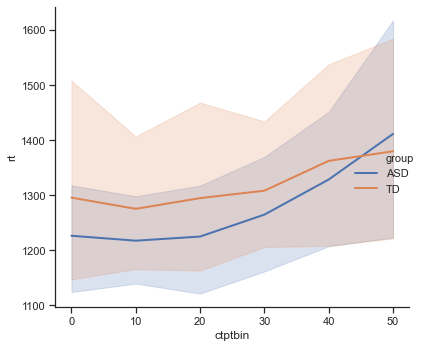

In [221]:
df['ctptbin']=pd.cut(df.abs_ctpt.dropna(), bins=9, labels=range(0,90,10))
dfsumctpt = df.query("correct==1 & dsd==10 & trialN > 0").groupby(['subjectId', 'group', 'ctptbin']).rt.mean().reset_index()

g = sns.relplot(x="ctptbin", y="rt", hue="group", kind="line", data=dfsumctpt);

# Role-reversal effect

In [22]:
print(len(df))
##ACCOUNT FOR CIRCULARITY
data1 = df[df.ctpd< -60]
data1.ctpd = data1.ctpd + 180
data2 = df[df.ctpd> 60]
data2.ctpd = data2.ctpd - 180
df_circ = df.append([data1,data2], ignore_index=True)
print(len(df_circ))

43943
57411


In [58]:
%%R

nrow(df_filter)
##ACCOUNT FOR CIRCULARITY
data1<-filter(df_filter,ctpd< -60)
data1 <- data1 %>% mutate(ctpd = ctpd + 180)
data2<-filter(df_filter,ctpd> 60)
data2 <- data2 %>% mutate(ctpd = ctpd - 180)
df_filter_circ <-rbind(df_filter,data1,data2)
nrow(df_filter_circ)

##ACCOUNT FOR CIRCULARITY
data1<-df_filter[df_filter$cdpd<-60,]
data1 <- data1 %>% mutate(cdpd = cdpd + 180)
data2<-df_filter[df_filter$cdpd>60,]
data2 <- data2 %>% mutate(cdpd = cdpd - 180)
df_filter_circ_cdpd <-rbind(df_filter,data1,data2)

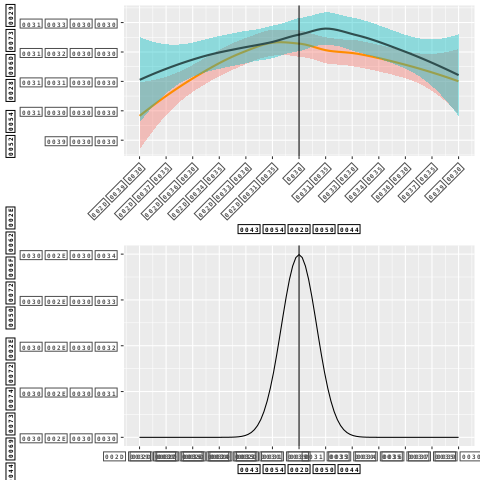

In [59]:
%%R

# rt ~ ct-pd plot
ctpd_plot <-df_filter_circ%>%
  filter(correct==1) %>% #only RTs for correct responses
  filter(previous_correct ==1) %>% #Only after a correct trial
  filter(dsd==5) %>% #For test streaks with Gaussian distr
  filter(trialN == 0) %>%#Only first trial of test streak 
  ggplot(aes(x=ctpd,y=rt, color=group,show.legend = FALSE)) + geom_smooth(method = "loess", aes(fill = group,show.legend = FALSE)) +  xlab("CT-PD") + ylab("RT (ms)")  + scale_x_continuous(breaks = seq(-90,90, by=15), limits=c(-90,90))   + scale_color_manual(values=c("darkorange", "darkslategrey")) + geom_vline(xintercept = 0) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

#Plot of distribution of distractors
distribution_plot <- ggplot(data = data.frame(x = c(-90, 90)), aes(x)) +
  stat_function(fun = dnorm, n = 101, args = list(mean = 0, sd = 10))  + scale_x_continuous(breaks = seq(-90,90, by=15), limits=c(-90,90))+  xlab("CT-PD")+ geom_vline(xintercept = 0)+ ylab("Distr. Prob.")

# rt ~ absolute ct-pd plot
abs_ctpd_plot <-df_filter_circ %>%
  mutate(abs_ctpd = abs(ctpd)) %>%
  filter(correct==1) %>% #only RTs for correct responses
  filter(previous_correct ==1) %>% #Only after a correct trial
  filter(dsd==5) %>% #For test streaks with Gaussian distr
  filter(trialN == 0) %>% #Only first trial of test streak 
  ggplot(aes(x=abs_ctpd,y=rt,color=group)) + geom_smooth(method = "loess", aes(fill = group)) + scale_color_manual(values=c("#4c72b0", "#dd8452")) + scale_x_continuous(breaks = seq(0,90, by=15), limits=c(0,90)) + xlab("absolute CT-PD") + ylab("Mean Raction Time (ms)")

#Plot of half distribution of distractors
half_distribution_plot <- ggplot(data = data.frame(x = c(-90, 90)), aes(x)) +
  stat_function(fun = dnorm, n = 101, args = list(mean = 0, sd = 10))  +  scale_x_continuous(breaks = seq(-90,90, by=15), limits=c(0,90))+  xlab("CT-PD")+ ylab("Distr. Prob.")

plot_grid(ctpd_plot + theme(legend.position="none"), distribution_plot,ncol=1,align = 'v')

In [20]:
from plotnine import *
from plotnine.data import *


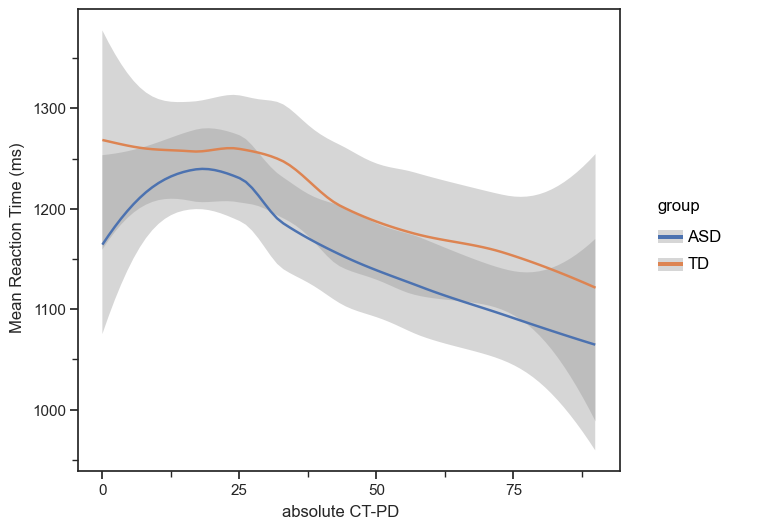

<ggplot: (8766033651604)>

In [21]:
dfp = df[(df.previous_correct==1) & (df.correct==1) & (df.dsd==5) & (df.trialN == 0)]

(
ggplot(dfp, aes(x='abs_ctpd',y='rt',color='group')) 
    + geom_smooth(method = "loess") 
    + xlab("absolute CT-PD") 
    + ylab("Mean Reaction Time (ms)")
    + scale_color_manual(values=["#4c72b0", "#dd8452"]) 
    + theme_seaborn(style='ticks')
    + theme(figure_size=(7, 6))
)




In [32]:
mu=0
sigma= 10

dfx = pd.DataFrame({'x': np.linspace(mu, mu + 9*sigma, 10000)})
g = (
ggplot(dfx, aes(x='x')) 
    + stat_function(fun = stats.norm.pdf, n = 101, args = [0, 10]) 
    +  xlab("absolute CT-PD")+ ylab("Distr. Prob.")
    + theme_seaborn(style='ticks')
    + theme(figure_size=(6, 3))
)



In [33]:
g.save('test.png', dpi=300)

R[write to console]: `geom_smooth()` using formula 'y ~ x'



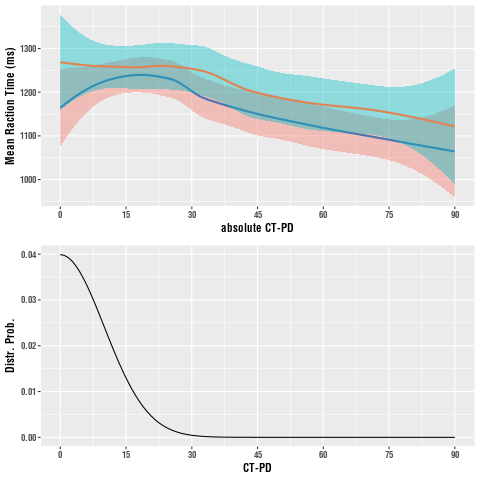

In [432]:
%%R

plot_grid(abs_ctpd_plot + theme(legend.position="none"), half_distribution_plot,ncol=1,align = 'v')

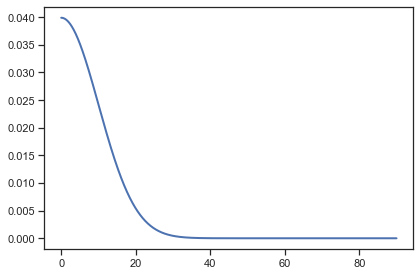

In [425]:
import math
mu = 0
sigma = 10
x = np.linspace(mu, mu + 9*sigma, 10000)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

In [63]:
%%R

df_steps<-df_filter %>%
  mutate(abs_ctpd = abs(ctpd)) %>%
  filter(correct==1) %>% #only RTs for correct responses
  filter(previous_correct ==1) %>% #Only after a correct trial
  filter(dsd==5) %>% #For test streaks with Gaussian distr
  filter(trialN == 0) #%>% #Only first trial of test streak 
  #group_by(subjectId,group,abs_ctpd) %>%
  #summarise(rt=mean(rt), log_rt=mean(log_rt), totBlockN=totBlockN)


df_steps$step_ctpd[df_steps$abs_ctpd< 5] <- "0-5"
df_steps$step_ctpd[df_steps$abs_ctpd> 4 & df_steps$abs_ctpd< 15] <- "05-15"
df_steps$step_ctpd[df_steps$abs_ctpd> 14 & df_steps$abs_ctpd< 25] <- "15-25"
df_steps$step_ctpd[df_steps$abs_ctpd> 24 & df_steps$abs_ctpd< 35] <- "25-35"
df_steps$step_ctpd[df_steps$abs_ctpd> 34 & df_steps$abs_ctpd< 50] <- "35-50"
df_steps$step_ctpd[df_steps$abs_ctpd> 49 & df_steps$abs_ctpd< 70] <- "50-70"
df_steps$step_ctpd[df_steps$abs_ctpd> 69 ] <- "70-90"


df_steps$step_ctpd = as.factor(df_steps$step_ctpd)

df_steps_plot <- df_steps%>%
  group_by(subjectId,step_ctpd, group)%>%
  summarise(rt = mean(rt))%>%
  ggplot(aes(x=step_ctpd,y=rt, color = group)) + stat_summary(fun.y=base::mean, geom="point", size =3) + stat_summary(fun.y=base::mean, geom="line")+ stat_summary(fun.y=base::mean, geom="line",size=1.5, aes(group = group))+ stat_summary(fun.data = "mean_se", geom="errorbar", width = 0.2)  + theme_classic() + xlab("Absolute CT-PD") + ylab("Mean Reaction Time (ms)")  + scale_color_manual(values=c("darkorange", "darkslategrey")) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

df_steps_plot

lmer_RT_step<-df_steps%>%
  lmer(log_rt ~ step_ctpd * (1|subjectId),REML=F,control = lmerControl(optimizer ="Nelder_Mead"),   data= .)
summary(lmer_RT_step)


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log_rt ~ step_ctpd * (1 | subjectId)
   Data: .
Control: lmerControl(optimizer = "Nelder_Mead")

     AIC      BIC   logLik deviance df.resid 
  4469.7   4528.4  -2225.8   4451.7     5070 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3714 -0.6742 -0.1347  0.5370  6.4507 

Random effects:
 Groups    Name        Variance Std.Dev.
 subjectId (Intercept) 0.02868  0.1693  
 Residual              0.13649  0.3695  
Number of obs: 5079, groups:  subjectId, 49

Fixed effects:
                 Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     1.246e-01  3.235e-02  1.411e+02   3.850 0.000178 ***
step_ctpd05-15  4.325e-03  2.528e-02  5.032e+03   0.171 0.864162    
step_ctpd15-25  1.003e-02  2.530e-02  5.031e+03   0.397 0.691707    
step_ctpd25-35  6.726e-03  2.520e-02  5.032e+03   0.267 0.789566    
step_ctpd35-50 -6.021e-02  2.513e-02  5.031e+03  -2.3

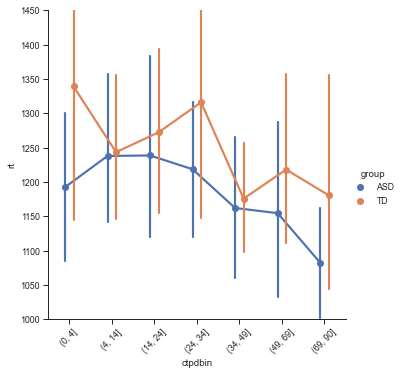

In [28]:
dfsteps = df.query("previous_correct==1 & correct==1 & dsd==5 & trialN == 0")
bins = pd.IntervalIndex.from_tuples([(0, 4), (4, 14), (14, 24),(24,34),(34,49),(49,69), (69,90)])
dfsteps['ctpdbin'] = pd.cut(dfsteps.abs_ctpd, bins, [10,20,30,50,70,90])#, [int(i) for i in np.linspace(0,90, 7)])#bins, labels=False) #["0-5","5-15", "15-25","25-35","35-50","50-70","70-90"]
dfsteps.ctpdbin = dfsteps.ctpdbin.astype('category')

dfstepssum = dfsteps.groupby(['group','subjectId', 'ctpdbin']).mean().reset_index()

g = sns.catplot(x="ctpdbin", y="rt", hue="group", kind="point", data=dfstepssum, dodge=.2);
g.set(ylim=[1000,1450]);
g.set_xticklabels(rotation=45);




In [261]:
%%R

df_steps$step_ctpd = as.numeric(df_steps$step_ctpd)

model = list(
  rt ~ 1,  # int_1
  1 + (1|group) ~ 0 + step_ctpd  # cp_1, cp_1_sd, cp_1_id[i]
)

fit = mcp(model, df_steps)
plot(fit, facet_by = "group", cp_dens = FALSE)



model_null = list(
  rt ~ 1,  # int_1
  ~ 0 + step_ctpd  # cp_1, cp_1_sd, cp_1_id[i]
)


# Fit it
fit_null = mcp(model_null, df_steps)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5079
   Unobserved stochastic nodes: 4
   Total graph size: 15310

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |**************************************************| 100%


R[write to console]: Finished sampling in 199.5 seconds




In [263]:
%%R

fit$loo = loo(fit)
fit_null$loo = loo(fit_null)

loo::loo_compare(fit$loo, fit_null$loo)

       elpd_diff se_diff
model1  0.0       0.0   
model2 -2.2       2.0   


In [257]:
%%R

plot(fit, facet_by="group", ncol = 2)
#summary(fit) 
ranef(fit)

             name       mean       lower      upper     Rhat n.eff
1 cp_1_group[ASD] -0.6322306 -1.51667141 0.09595524 1.001737  1730
2  cp_1_group[TD]  0.6322306 -0.09595524 1.51667141 1.001737  1730


TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

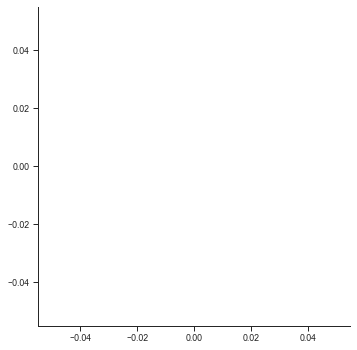

In [29]:
g = sns.relplot(x="ctpdbin", y="rt", hue="group", kind="line",units='subjectId', data=dfstepssum, estimator=None, legend=False);
plt.setp([g.ax.get_children()],alpha=.2)
sns.set(style="ticks", rc={"lines.linewidth": 2})
sns.lineplot(x="ctpdbin", y="rt", hue="group",ci=None, data=dfstepssum);
g.set(ylim=[750,2000], xlabel='Trial number', ylabel='RT')
g.savefig('trialbyrt.png', dpi=300)

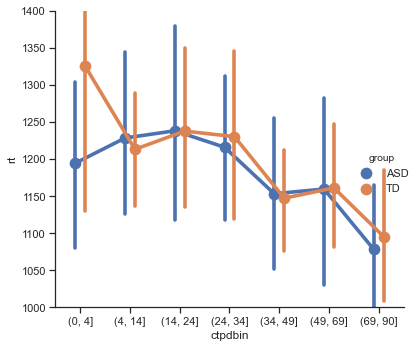

In [362]:
dfsteps = df.query("previous_correct==1 & correct==1 & dsd==5 & trialN == 0")
bins = pd.IntervalIndex.from_tuples([(0, 4), (4, 14), (14, 24),(24,34),(34,49),(49,69), (69,90)])
dfsteps['ctpdbin'] = pd.cut(dfsteps.abs_ctpd, bins, labels=False) #["0-5","5-15", "15-25","25-35","35-50","50-70","70-90"]
dfsteps.ctpdbin = dfsteps.ctpdbin.astype('category')



dfstepssum = dfsteps.groupby(['group','subjectId', 'ctpdbin']).mean().reset_index()

g = sns.catplot(x="ctpdbin", y="rt", hue="group", kind="point", data=dfstepssum, dodge=.2);
g.set(ylim=[1000,1400])

In [243]:
%%R

library(mcp)

model = list(
  rt ~ 1 + abs_ctpd,          # intercept + slope
  rt + (1|subjectId) ~ 0 + abs_ctpd  # joined slope, varying by id
)
fit = mcp(model, df_filter)
plot(fit, facet_by = "subjectId", cp_dens = FALSE)

R[write to console]: Error in unpack_cp(row$form_cp, i) : 
  Error in segment 2 (change point): Only intercepts (1 or rel(1)) are allowed in population-level effects.




Error in unpack_cp(row$form_cp, i) : 
  Error in segment 2 (change point): Only intercepts (1 or rel(1)) are allowed in population-level effects.


In [491]:
%%R

lmer_RT_step<-df_steps%>%
  lmer(log_rt ~ step_ctpd * group + (step_ctpd|subjectId),REML=F,control = lmerControl(optimizer ="Nelder_Mead"), data= .)
summary(lmer_RT_step)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log_rt ~ step_ctpd * group + (step_ctpd | subjectId)
   Data: .
Control: lmerControl(optimizer = "Nelder_Mead")

     AIC      BIC   logLik deviance df.resid 
  4580.9   4861.8  -2247.4   4494.9     5036 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9284 -0.6825 -0.1267  0.5322  6.4280 

Random effects:
 Groups    Name           Variance Std.Dev. Corr                               
 subjectId (Intercept)    0.17151  0.4141                                      
           step_ctpd05-15 0.01914  0.1384   -0.62                              
           step_ctpd15-25 0.02474  0.1573    0.32  0.47                        
           step_ctpd25-35 0.01954  0.1398    0.30  0.48  1.00                  
           step_ctpd35-50 0.02595  0.1611    0.05  0.58  0.87  0.85            
           step_ctpd50-70 0.03016  0.1737    0.21  0.34  0.77  0.74  0.87      
     

R[write to console]: 
Correlation matrix not shown by default, as p = 14 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




convergence code: 0
unable to evaluate scaled gradient
Model failed to converge: degenerate  Hessian with 1 negative eigenvalues
failure to converge in 10000 evaluations



In [487]:
%%R

df_steps<-df_filter %>%
  mutate(abs_ctpd = abs(ctpd)) %>%
  filter(correct==1) %>% #only RTs for correct responses
  filter(previous_correct ==1) %>% #Only after a correct trial
  filter(dsd==5) %>% #For test streaks with Gaussian distr
  filter(trialN == 0) #%>% #Only first trial of test streak 
  #group_by(subjectId,group,abs_ctpd) %>%
  #summarise(rt=mean(rt), log_rt=mean(log_rt), totBlockN=totBlockN)


lmer_RT_step<-df_steps%>%
  lmer(log_rt ~ abs_ctpd * group + (1|subjectId),REML=T, data= .)
summary(lmer_RT_step)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_rt ~ abs_ctpd * group + (1 | subjectId)
   Data: .

REML criterion at convergence: 4502.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4145 -0.6757 -0.1386  0.5411  6.5111 

Random effects:
 Groups    Name        Variance Std.Dev.
 subjectId (Intercept) 0.02972  0.1724  
 Residual              0.13687  0.3700  
Number of obs: 5079, groups:  subjectId, 49

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       1.285e-01  3.725e-02  5.360e+01   3.450   0.0011 ** 
abs_ctpd         -1.410e-03  2.336e-04  5.029e+03  -6.035 1.71e-09 ***
groupTD           3.342e-02  5.218e-02  5.371e+01   0.640   0.5246    
abs_ctpd:groupTD  2.473e-05  3.289e-04  5.029e+03   0.075   0.9401    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) abs_ct gropTD
abs_ctpd    -0.261     

## Difference in RTs between test trials where target orientation lies within vs out of the range of the previous distractor distribution

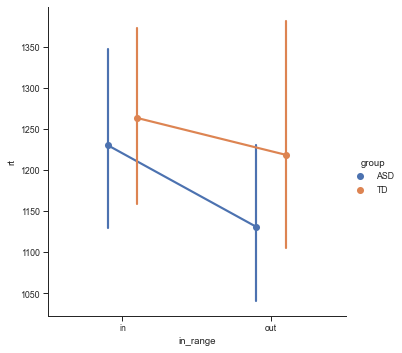

In [8]:
dfrange = df.query("previous_correct==1 & correct==1 & dsd==5 & trialN == 0")

#dfrange['in_range'] = np.where(dfrange.abs_ctpd > 30, "out", "in")

dfrangesum = dfrange.groupby(['group','subjectId', 'in_range']).mean().reset_index()


g = sns.catplot(x="in_range", y="rt", hue="group", units='subjectId', kind="point", data=dfrangesum, dodge=.2);



In [168]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ in_range * group", groups="subjectId",data=dfrangesum, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                   98
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                   2
                      Estimating Equations   Max. cluster size:                   2
Family:                           Gaussian   Mean cluster size:                 2.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                      do, 09 jan 2020   Scale:                       45355.698
Covariance type:                    robust   Time:                         17:28:22
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1216.5288     50.267   

## Does in range effect vary with SP, SRS, IU?

Yes, no, no
But note few datapoints for SP (missing data)

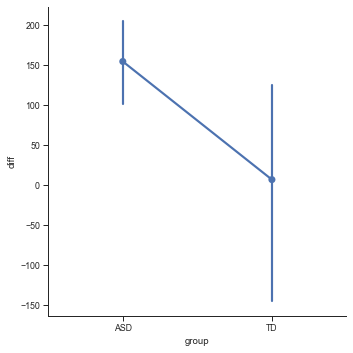

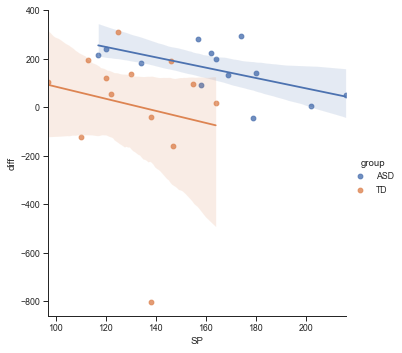

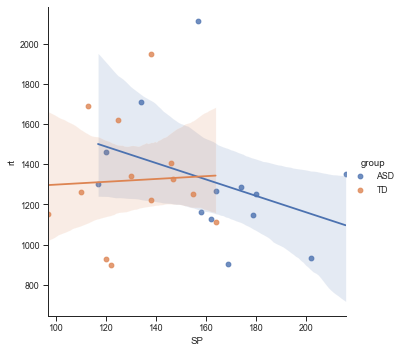

In [12]:
rangediff = dfrangesum.pivot_table(index=['group','subjectId','SP'],columns='in_range',values='rt').reset_index()

rangediff['diff']= rangediff['in'] - rangediff['out']



g = sns.catplot(x="group", y="diff", units='subjectId', kind="point", data=rangediff, dodge=.2);


sns.lmplot(x="SP", y="diff", hue="group", data=rangediff);


dfbase= dfrange.groupby(['group','subjectId', 'in_range']).mean().reset_index()

sns.lmplot(x="SP", y="rt", hue="group", data=dfbase[dfbase.in_range=='in']);

In [394]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ SP * group * in_range", groups="subjectId",data=dfbase, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                   52
Model:                                 GEE   No. clusters:                       26
Method:                        Generalized   Min. cluster size:                   2
                      Estimating Equations   Max. cluster size:                   2
Family:                           Gaussian   Mean cluster size:                 2.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                      do, 23 jan 2020   Scale:                       57593.192
Covariance type:                    robust   Time:                         16:27:55
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       1901.5199    3

**But only about half of participants took the SP:**

In [129]:
dfsumQ.groupby(['group']).SP.count()

group
ASD    13
TD     13
Name: SP, dtype: int64

If anything, higher SP is associated with lower influence of previous distribution.

# Adult data Chetverikov et al Cognition 2016

In [9]:
dfa = pd.read_csv('Chetverikov2016_visual_ensemble_representations_exp1.csv')

In [11]:
dfa

,expName,subjectId,subjectGender,subjectAge,session,block,trial,targetOri,targetPos,distrMean,dtype,dsd,targetDist,t_dist_to_prev_d,rt,correct,prev_correct
0,distr_stats,1,F,26,1,0,0,166,11,51,norm,10,-65,NaN,949.935604,1,NaN
1,distr_stats,1,F,26,1,0,1,166,24,51,norm,10,-65,NaN,732.896351,1,1.0
2,distr_stats,1,F,26,1,0,2,166,23,51,norm,10,-65,NaN,623.737920,1,1.0
3,distr_stats,1,F,26,1,0,3,166,26,51,norm,10,-65,NaN,795.503562,1,1.0
4,distr_stats,1,F,26,1,0,4,166,7,51,norm,10,-65,NaN,888.690341,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32772,distr_stats,10,M,24,2,272,2,80,18,12,norm,15,68,-72.0,679.772112,1,0.0
32773,distr_stats,10,M,24,2,272,3,80,23,12,norm,15,68,-72.0,1022.215290,1,1.0
32774,distr_stats,10,M,24,2,272,4,80,1,12,norm,15,68,-72.0,1086.781500,1,1.0
32775,distr_stats,10,M,24,2,272,5,80,13,12,norm,15,68,-72.0,675.042335,0,1.0


In [12]:
from plotnine import *
from plotnine.data import *


In [17]:
#dfa['abs_ctpd'] = abs(dfa.t_dist_to_prev_d)


dfp = dfa[(dfa.correct==1) & (dfa.dsd==5) & (dfa.dtype=='norm')]

g = (
ggplot(dfp, aes(x='abs_ctpd',y='rt')) 
    + geom_smooth(method = "loess") 
    + xlab("absolute CT-PD") 
    + ylab("Mean Reaction Time (ms)")
    + scale_color_manual(values=["#4c72b0", "#dd8452"]) 
    + theme_seaborn(style='ticks')
    + theme(figure_size=(7, 6))
)



In [18]:
g.save('chetverikov2016Adults.png', dpi=300)

In [40]:
r = np.random.randint(0,1000,10000)



0.8632406057841824

In [44]:
print(np.mean(r))
print(np.std(r))

for i in range(50):
    p= [ n+np.random.randint(-100,+100) for n in r ]
    print(np.mean(p)-np.mean(r))
    print(np.std(p)-np.std(r))

498.7294
287.3604043281537
0.10370000000000346
4.653877590368211
0.678100000000029
5.818948702972932
0.40510000000000446
5.271541654765258
-0.6481999999999744
5.07482680270715
-0.35489999999998645
5.33982431840883
-0.2685999999999922
5.679484873572562
-0.9644999999999868
5.359502114831457
-1.443300000000022
5.726668138016294
-0.5489000000000033
6.16735027053835
-0.8894000000000233
5.513081327342263
0.22719999999998208
6.317864729057931
-1.024000000000001
5.54438534050297
0.04189999999999827
5.841167625869048
-0.30380000000002383
5.867850218777676
0.18729999999999336
5.600640797490939
-0.032199999999988904
5.6512434132969815
0.5731000000000108
6.108076081157037
-0.19089999999999918
5.973375038884058
-0.9520999999999731
5.750840602350422
0.1408999999999878
5.696172253758164
-0.2676000000000158
5.146402670862983
-0.358099999999979
5.506250715246551
-0.5312000000000126
6.4247905281562225
-1.203800000000001
5.22683692586952
-0.44779999999997244
5.4400599840464565
-0.9615000000000009
6.15445